<a href="https://colab.research.google.com/github/artyom-zolotarevskiy/0_git_basics/blob/master/gpt3_finetune_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Классификация текста на базе GPT3**

Этот блокнот используется для точной настройки GPT3 для классификации текста с использованием 
библиотеки [Huggingface](https://huggingface.co/transformers/) [transformers](https://github.com/huggingface/transformers) на пользовательском датасете.

**Главная идея:**
GPT3 является транформером на базе блоков декодера (в отличие от берта), т.е. последний токен входной последовательности используется для предсказания следующего токена. Это означает, что последний токен входной последовательности содержит всю информацию, необходимую для прогнозирования. Поэтому мы можем использовать эту информацию для прогнозирования в задаче классификации вместо задачи генерации текста.


## **Скачиваем датасет**


In [1]:
!wget https://github.com/artyom-zolotarevskiy/ru-gpt-3-training-legal/raw/main/dataset.zip
!unzip /content/dataset.zip

--2023-05-16 03:57:56--  https://github.com/artyom-zolotarevskiy/ru-gpt-3-training-legal/raw/main/dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/artyom-zolotarevskiy/ru-gpt-3-training-legal/main/dataset.zip [following]
--2023-05-16 03:57:56--  https://raw.githubusercontent.com/artyom-zolotarevskiy/ru-gpt-3-training-legal/main/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12404308 (12M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  11.83M  --.-KB/s    in 0.1s    

2023-05-16 03:57:56 (121 MB/s) - ‘dataset.zip’ saved [1240430

In [2]:
# Устанавливаем библиотеку transformers 
!pip install -q transformers==4.29.1
# Устанавливаем полезные helper функции.
!pip install -q git+https://github.com/gmihaila/ml_things.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.3 MB/s eta 0:00:00


## **Imports**

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

* `set_seed(123)` - Always good to set a fixed seed for reproducibility.
* `epochs` - Number of training epochs (authors recommend between 2 and 4).
* `batch_size` - Number of batches - depending on the max sequence length and GPU memory. For 512 sequence length a batch of 10 USUALY works without cuda memory issues. For small sequence length can try batch of 32 or higher.
max_length - Pad or truncate text sequences to a specific length. I will set it to 60 to speed up training.
* `device` - Look for gpu to use. Will use cpu by default if no gpu found.
* `model_name_or_path` - Name of transformers model - will use already pretrained model. Path of transformer model - will load your own model from local disk. In this tutorial I will use `gpt2` model.
* `labels_ids` - Dictionary of labels and their id - this will be used to convert string labels to numbers.
* `n_labels` - How many labels are we using in this dataset. This is used to decide size of classification head.

In [3]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 3

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 4

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 1024

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'sberbank-ai/rugpt3small_based_on_gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'criminal': 0, 'administrative': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

## **Helper Functions**

I like to keep all Classes and functions that will be used in this notebook under this section to help maintain a clean look of the notebook:

<br>

**SudactDataset(Dataset)**

If you worked with PyTorch before, this is pretty standard. We need this class to read in our dataset, parse it and return texts with their associated labels.

In this class I only need to read in the content of each file, use fix_text to fix any Unicode problems and keep track of positive and negative sentiments.

I will append all texts and labels in lists.

There are three main parts of this PyTorch Dataset class:

* **init()** where we read in the dataset and transform text and labels into numbers.
* **len()** where we need to return the number of examples we read in. This is used when calling len(SudactDataset()).
* **getitem()** always takes as an input an int value that represents which example from our examples to return from our dataset. If a value of 3 is passed, we will return the example form our dataset at position 3.

<br>

**Gpt2ClassificationCollator**

I use this class to create the Data Collator. This will be used in the DataLoader to create the bathes of data that get fed to the model. I use the tokenizer and label encoder on each sequence to convert texts and labels to number.

Lucky for us, Hugging Face thought of everything and made the tokenizer do all the heavy lifting (split text into tokens, padding, truncating, encode text into numbers) and is very easy to use!

There are two main parts of this Data Collator class:

* **init()** where we initialize the tokenizer we plan to use, how to encode our labels and if we need to set the sequence length to a different value.

* **__call__()** used as function collator that takes as input a batch of data examples. It needs to return an object with the format that can be fed to our model. Luckily our tokenizer does that for us and returns a dictionary of variables ready to be fed to the model in this way: `model(**inputs)`. Since we are fine-tuning the model I also included the labels.





<br>

**train(dataloader, optimizer_, scheduler_, device_)**

I created this function to perform a full pass through the DataLoader object (the DataLoader object is created from our Dataset* type object using the **SudactDataset class). This is basically one epoch train through the entire dataset.

The dataloader is created from PyTorch DataLoader which takes the object created from SudactDataset class and puts each example in batches. This way we can feed our model batches of data!

The optimizer_ and scheduler_ are very common in PyTorch. They are required to update the parameters of our model and update our learning rate during training. There is a lot more than that but I won't go into details. This can actually be a huge rabbit hole since A LOT happens behind these functions that we don't need to worry. Thank you PyTorch!

In the process we keep track of the actual labels and the predicted labels along with the loss.

<br>

**validation(dataloader, device_)**

I implemented this function in a very similar way as train but without the parameters update, backward pass and gradient decent part. We don't need to do all of those VERY computationally intensive tasks because we only care about our model's predictions.

I use the DataLoader in a similar way as in train to get out batches to feed to our model.

In the process I keep track of the actual labels and the predicted labels along with the loss.


In [4]:
class SudactDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    self.texts = []
    self.labels = []
    # Since the labels are defined by folders with data we loop 
    # through each label.
    for label in ['administrative', 'criminal']:
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      # Go through each file and read its content.
      for file_name in tqdm(files_names, desc=f'{label} files'):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        self.texts.append(content)
        # Save encode labels.
        self.labels.append(label)

    # Number of exmaples.
    self.n_examples = len(self.labels)
    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        #print(texts)
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        #print(labels)
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        #print(labels)
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Load Model and Tokenizer**

Loading the three essential parts of the pretrained GPT2 transformer: configuration, tokenizer and model. 

For this example I will use `gpt2` from HuggingFace pretrained transformers. You can use any variations of GP2 you want.

In creating the `model_config` I will mention the number of labels I need for my classification task. Since I only predict two sentiments: positive and negative I will only need two labels for `num_labels`.

Creating the `tokenizer` is pretty standard when using the Transformers library. After creating the tokenizer it is critical for this tutorial to set padding to the left `tokenizer.padding_side = "left"` and initialize the padding token to `tokenizer.eos_token` which is the GPT2's original end of sequence token. This is the most essential part of this tutorial since GPT2 uses the last token for prediction so we need to pad to the left.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model I used `GPT2ForSequenceClassification`.
Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.
Finally we will need to move the model to the device we defined earlier.



In [5]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
tokenizer.pad_token_id = model.config.pad_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading tokenizer...


Loading model...


Some weights of the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [27]:
model.config.pad_token_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


50256

## **Dataset and Collator**

This is where I create the PyTorch Dataset and Data Loader with Data Collator objects that will be used to feed data into our model.

This is where I use the **SudactDataset** class to create the PyTorch Dataset that will return texts and labels.

Since we need to input numbers to our model we need to convert the texts and labels to numbers. This is the purpose of a collator! It takes data outputted by the PyTorch Dataset and passed through the Data Collator function to output the sequence for our model.

I'm keeping the tokenizer away from the PyTorch Dataset to make the code cleaner and better structured. You can obviously use the tokenizer inside the PyTorch Dataset and output sequences that can be used straight into the model without using a Data Collator.

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for GPT2.

In [21]:
texts = ['11RS0016-01-2020-000399-74 Дело № 5-111/2020\nПОСТАНОВЛЕНИЕ\n28 мая 2020 г. с. Выльгорт\nСудья Сыктывдинского районного суда Республики Коми Самарин А.И.,\nпри секретаре судебного заседания Старцевой Н.С.,\nс участием: лица, в отношении которого ведется производство по делу об административном правонарушении, Балашова В.А.,\nпредставителя лица, в отношении которого ведется производство по делу об административном правонарушении, - П.\nпредставителя потерпевших - Ш.,\nрассмотрев в открытом судебном заседании дело об административном правонарушении, предусмотренном ст.\n12.24\nч.2 Кодекса Российской Федерации об административных правонарушениях (далее КоАП РФ), в отношении\nБалашова В.А., ,\nУСТАНОВИЛ:\n23.03.2020 инспектором ДПС ОВ ДПС ГИБДД ОМВД России по Сыктывдинскому району составлен протокол 11 АА № 901966 об административном правонарушении, предусмотренном ст.\n12.24\nч. 2 Кодекса РФ об административных правонарушениях, в отношении Балашова В.А., в соответствии с которым 29.06.2019 в 12:10 около на 32 км автодороги Сыктывкар-Ухта, водитель Балашов В.А., управляя транспортным средством марки «Форд Транзит», государственный регистрационный знак №», в нарушение п. 1.5 ПДД РФ не справился с управлением указанным транспортным средством, в результате чего совершил съезд в кювет с последующим опрокидыванием. В результате ДТП пассажирам Н. были причинены телесные повреждения, которые квалифицируются по признаку длительности расстройства здоровья как средний вред здоровью.\nЛицо, в отношении которого ведётся производство по делу об административном правонарушении, Балашов В.А. в судебном заседании вину в совершении административного правонарушения признал, в содеянном раскаялся.\nПредставитель П. доводы Балашова В.А. поддержал, указав, что не согласен с выводами проведенных экспертиз в части определения тяжести вреда, причиненных потерпевшим.\nПотерпевшие Н. в судебное заседание не явились, извещены о месте и времени судебного заседания надлежащим образом.\nПредставитель потерпевших Ш. в судебном заседании показал, что потерпевшие подтверждают, что являлись пассажирами автомашины под управлением водителя Балашова В.А.\nОГИБДД ОМВД России по Сыктывдинскому району, надлежащим образом извещенный о времени и месте судебного заседания, своего представителя не направил.\nСуд определил рассмотреть дело при имеющейся явке.\nЗаслушав пояснения лица, в отношении которого ведется производство по делу об административном правонарушении, потерпевшей, исследовав письменные материалы дела, судья приходит к выводу о виновности Балашова В.А. в совершении административного правонарушения, предусмотренного ст.\n12.24\nч. 2 Кодекса РФ об административных правонарушениях.\nВ соответствии с ч. 2 ст.\n12.24\nКодекса РФ об административных правонарушениях административным правонарушением признается нарушение Правил дорожного движения или правил эксплуатации транспортного средства, повлекшее причинение средней тяжести вреда здоровью потерпевшего, которое влечет наложение административного штрафа в размере от десяти тысяч до двадцати пяти тысяч рублей или лишение права управления транспортными средствами на срок от полутора до двух лет.\nСогласно пункту 1.5 Правил дорожного движения, утвержденных Постановлением Совета Министров - Правительства Российской Федерации от 23.10.1993 № 1090, участники дорожного движения должны действовать таким образом, чтобы не создавать опасности для движения и не причинять вреда.\nСудом установлено, что 29.06.2019 в 12:10 около на 32 км автодороги Сыктывкар-Ухта, водитель Балашов В.А., управляя транспортным средством марки «Форд Транзит», государственный регистрационный знак № в нарушение п. 1.5 ПДД РФ не справился с управлением указанным транспортным средством, в результате чего совершил съезд в кювет с последующим опрокидыванием. В результате ДТП пассажирам Н. были причинены телесные повреждения, которые квалифицируются по признаку длительности расстройства здоровья как средний вред здоровью.\nУказанные обстоятельства подтверждаются собранными по делу доказательствами: 11 АА № 901966 от 23.03.2020; рапортом оперативного дежурного от 29.06.2019 и от 01.07.2019; схемой места дорожно-транспортного происшествия от 29.06.2019; протоколом осмотра места ДТП от 29.06.2019; протоколом осмотра транспортного средства от 29.06.2019; объяснениями Балашова В.А. в судебном заседании, письменными объяснениями Балашова В.А., О.; протоколом о направлении на медицинское освидетельствование на состояние опьянения 11 РР 033364 от 29.06.2019; протоколом об административном правонарушении СК № 004713 от 07.08.2019, согласно которого в действиях Балашова В.А. имеются признаки состава административного правонарушения, предусмотренного ст.\n14.1\nч. 2 Кодекса РФ об административных правонарушениях; актом медицинского освидетельствования на состояние опьянения № 1382 от 29.06.2019 и справкой от 29.06.2019, согласно которым у Балашова В.А. установлено состояние опьянения; протоколом об административном правонарушении 11 АА № 880425 от 09.07.2019, согласно которого в действиях Балашова В.А. имеются признаки состава административного правонарушения, предусмотренного ст.\n12.8\nч. 1 Кодекса РФ об административных правонарушениях; протоколом изъятия вещей и документов 11 НН № 003178 от 29.06.2019; фототаблицей к осмотру места ДТП от 29.06.2019; разрешением № 005201 от 02.12.2016; свидетельством о государственной регистрации 11 № 002057870 от 29.01.2015; заключением экспертов № 2533, 2618 от 07.08.2019, согласно которого эксплуатация представленных на экспертизу шин с задней соси автомобиля Форд Транзит, государственный регистрационный знак «№ запрещена; заключением эксперта № 2/3187-19/2976-19 от 18.07.2019, согласно которому у Ф. обнаружены: закрытый перелом рукоятки грудины, кровоподтеки на передней брюшной стенке в центральной части на уровне лобка, в области нижнего внутреннего квадранта левой молочной железы, кровоподтек и ссадина на лице слева, которые могли образоваться от соударения о внутренние части салона автомобиля и действия ремня безопасности, пассажиром которого являлась Ф. при его опрокидывании, в условиях дорожно-транспортного происшествия от 29.06.2019, повреждения квалифицируется как средний вред здоровью; заключением эксперта № 2/3566-19/3934-19 от 27.09.2019, согласно которому у С. обнаружены: закрытая черепно-мозговая травма с сотрясением головного мозга, кровоподтек вокруг орбиты правого глаза, множественные мелкие рубцы – на передней поверхности ушной раковины в верхней трети, надбровной области справа и правой щеке, на передней поверхности правого предплечья в средней трети и в проекции возвышения 1-го пальца справа, как следствие заживления поверхностных резанных ран, ссадины головы, закрытый неосложненный перелом тела 12-го грудного позвонка, которые могли образоваться от соударения о внутренние части салона автомобиля, пассажиром которого являлась С. при его опрокидывании, в условиях дорожно-транспортного происшествия от 29.06.2019, повреждения квалифицируется как средний вред здоровью; заключением эксперта № 2/3687-19/3978-19 от 30.09.2019, согласно которому у Н. обнаружены: закрытый перелом нижней трети левой малоберцовой кости без смещения, ушибленная рана правой стопы, зажившая рубцом, ссадины лица, левой голени, кровоподтек теменной области, которые могли образоваться в результате ударов о внутренние части салона автобуса, пассажиром которого являлась Н. в условиях дорожно-транспортного происшествия от 29.06.2019, повреждения квалифицируется как средний вред здоровью.\nСуд не находит оснований не доверять представленным материалам, равно как и протоколу об административном правонарушении, так как он составлен компетентным лицом, не противоречит остальным материалам дела и соответствует требованиям ст.\n28.2\nКодекса РФ об административных правонарушениях.\nУ суда не имеется оснований не доверять выводам заключениям экспертов, поскольку экспертизы проведены в специализированном экспертном учреждении в соответствии с требованиями уголовно – процессуального законодательства Российской Федерации лицами, имеющими специальные познания. Заключения экспертов научно обоснованы, аргументировано, даны специалистами высокой квалификации, каких - либо объективных данных, позволяющих подвергнуть сомнению достоверность и обоснованность указанных экспертных заключений, у суда не имеется.\nВопреки доводам Балашова В.А. и его представителя, судом не может расцениваться как основание для признания заключений экспертов недопустимыми доказательствами то, что Балашов В.А. и его представитель были ознакомлены с заключением судебно-медицинских экспертиз по прошествии значительного времени, уже после проведения экспертных исследований, так как это не сказалось на научной обоснованности и объективности подготовленных заключений. Кроме того, и при таких условиях сторона защиты не была лишена возможности заявлять отводы экспертам, оспаривать выводы экспертиз, настаивать на проведении дополнительных или повторных экспертиз. Несвоевременное ознакомление с заключениями экспертиз не препятствовало Балашову В.А. и его представителю в реализации своих прав и не влечет признание указанных актов недопустимыми доказательствами. Ходатайств о постановлении дополнительных вопросов, заявлений об отводе не имелось.\nОценив доказательства в их совокупности, суд приходит к выводу, что вина Балашова В.А. в совершении административного правонарушения полностью доказана, и его действия суд квалифицирует по ст.\n12.24\nч. 2 Кодекса РФ об административных правонарушениях - нарушение Правил дорожного движения, повлекшее причинение средней тяжести вреда здоровью потерпевшего.\nВ соответствии с общими правилами назначения административного наказания, основанными на принципах справедливости, соразмерности и индивидуализации ответственности, административное наказание за совершение административного правонарушения назначается в пределах, установленных законом, предусматривающим ответственность за данное административное правонарушение, в соответствии с Кодекса РФ об административных правонарушениях (ст.\n4.1\nч. 1 Кодекса РФ об административных правонарушениях).\nВ соответствии с ст.\n4.1\nч. 2 Кодекса РФ об административных правонарушениях при назначении административного наказания физическому лицу учитываются характер совершенного им административного правонарушения, личность виновного, его имущественное положение, обстоятельства, смягчающие и отягчающие административную ответственность.\nИз системного толкования приведенных норм Кодекса РФ об административных правонарушениях следует, что судья, орган, должностное лицо, рассматривающие дело об административном правонарушении, при назначении наказания лицу, в отношении которого ведется производство по делу об административном правонарушении соответствующего административного наказания в пределах санкции статьи, предусматривающей ответственность за административное правонарушение, основываясь на принципах справедливости и соразмерности должны учесть характер совершенного административного правонарушения, вредные последствия, наступившие в результате совершения данного правонарушения виновным лицом.\nОбстоятельством, отягчающих административную ответственность Балашова В.А., в соответствии со ст.\n4.3 КоАП\nРФ, судом не установлено.\nВ качестве обстоятельств, смягчающих административную ответственность, суд признает раскаяние лица в содеянном.\nПри этом, учитывая характер правонарушения, принимая во внимание, что выявленное нарушение законодательства в сфере обеспечения безопасности дорожного движения повлекло причинение вреда здоровью граждан, учитывая характер, совокупность и обстоятельства совершенного правонарушения, имущественное и финансовое положение лица, привлекаемого к административной ответственности, ранее не привлекавшегося к административной ответственности, суд считает возможным назначить наказание в виде штрафа. Наказание в виде лишения права управления транспортными средствами, предусмотренное санкцией ч. 2 ст.\n12.24\nКодекса РФ об административных правонарушениях, суд считает возможным не применять.\nРуководствуясь ст.\n4.1\n,\n23.1\n,\n29.7\n,\n29.9\n,\n29.10\nКодекса РФ об административных правонарушениях, суд,\nпостановил:\nПризнать Балашова В.А. виновным в совершении административного правонарушения, предусмотренного ч. 2 ст.\n12.24\nКодекса РФ об административных правонарушениях, и назначить ему наказание в виде административного штрафа в размере 20 000 (двадцати тысяч) рублей.\nРеквизиты для уплаты штрафа:\nУФК по Республике Коми (МВД по РК) в ГРКЦ НБ Республики Коми банка России г. Сыктывкар.\nр/с № 40101810000000010004\nБИК 048702001\nКБК 18811630020016000140\nИНН 1101481581\nКПП 110101001\nОКТМО 87628000\nУИН 18810411200140000960\nРазъяснить Балашову В.А., что согласно ст.\n32.2\nч. 1 Кодекса РФ об административных правонарушениях, административный штраф должен быть уплачен в полном размере лицом, привлеченным к административной ответственности, не позднее шестидесяти дней со дня вступления постановления о наложении административного штрафа в законную силу.\nВ соответствии со ст.\n20.25\nч. 1 Кодекса РФ об административных правонарушениях, неуплата административного штрафа в срок, предусмотренный ст.\n32.2\nч. 1 Кодекса РФ об административных правонарушениях, влечет наложение административного штрафа в двукратном размере суммы неуплаченного административного штрафа, но не менее одной тысячи рублей, либо административный арест на срок до пятнадцати суток, либо обязательные работы на срок до пятидесяти часов.\nПостановление может быть обжаловано в Верховный суд Республики Коми через Сыктывдинский районный суд Республики Коми в течение 10 суток со дня получения копии постановления.\nСудья А.И. Самарин\nСуд:\nСыктывдинский районный суд (Республика Коми)\n(подробнее)\nСудьи дела:\nСамарин Андрей Иванович (судья)\n(подробнее)\nПоследние документы по делу:\nПостановление от 28 мая 2020 г. по делу № 5-111/2020\nПостановление от 26 мая 2020 г. по делу № 5-111/2020\nПостановление от 10 мая 2020 г. по делу № 5-111/2020\nПостановление от 8 мая 2020 г. по делу № 5-111/2020\nПостановление от 6 мая 2020 г. по делу № 5-111/2020\nПостановление от 7 февраля 2020 г. по делу № 5-111/2020\nПостановление от 20 января 2020 г. по делу № 5-111/2020\nПостановление от 20 января 2020 г. по делу № 5-111/2020\nПостановление от 8 января 2020 г. по делу № 5-111/2020\nПостановление от 5 января 2020 г. по делу № 5-111/2020\nПоказать все документы по этому делу\nСудебная практика по:\nОсуществление предпринимательской деятельности без регистрации или без разрешения\nСудебная практика по применению нормы ст. 14.1. КОАП РФ\nПо лишению прав за "пьянку" (управление ТС в состоянии опьянения, отказ от освидетельствования)\nСудебная практика по применению норм ст. 12.8, 12.26 КОАП РФ\nПо ДТП (причинение легкого или средней тяжести вреда здоровью)\nСудебная практика по применению нормы ст. 12.24. КОАП РФ\n', 'Дело № 1-8/2021\nУИД: 61RS0060-01-2020-000710-21\nПРИГОВОР\nИменем Российской Федерации\nпос. Чертково 22 марта 2021 года.\nЧертковский районный суд Ростовской области в составе:\nпредседательствующего судьи Кадурина С.А.,\nпри секретаре судебного заседания Вербицкой Е.Б.,\nс участием:\nгосударственного обвинителя Кривопустова И.И.,\nподсудимого Супрунца А.А.,\nзащитника – адвоката Расчетова И.В.,\nрассмотрев в открытом судебном заседании в помещении Чертковского районного суда Ростовской области материалы уголовного дела в отношении Супрунца Анатолия Анатольевича, , обвиняемого в совершении преступлений, предусмотренных ст.\n264.1 УК РФ\nи ст.\n264.1 УК РФ\n,\nустановил:\nСупрунец Анатолий Анатольевич, 21.02.2020 около 22 часов 12 минут имея умысел, направленный на нарушение правил дорожного движения, заведомо зная, что он на основании постановления мирового судьи судебного участка № 2 Чертковского судебного района Ростовской области от 24.09.2018 за совершение административного правонарушения, предусмотренного ч. 1 ст.\n12.26 КоАП\nРФ, то есть, невыполнение водителем законного требования сотрудника полиции о прохождении медицинского освидетельствования на состояние опьянения, подвергнут административному наказанию, находясь с явными признаками опьянения, управлял автомобилем «Мицубиси Лансер» государственный регистрационный знак по автодороге сообщением М-4 «Дон» - пос. Чертково Чертковский район Ростовской области. На контрольном посту пограничной службы, расположенном в районе х.Гусев, Супрунец А.А. не выполнил законные требования сотрудников пограничной службы о предоставлении паспорта и скрылся. Приехав ул. Степная в с. Маньково-Калитвенское Чертковского района Ростовской области, остановился возле домовладения № 12, где был задержан нарядом ПУ ФСБ России по Ростовской области и доставлен в Отделение в населённом пункте Чертково, расположенное по ул. Транспортная, 101 пос. Чертково Ростовской области, передан наряду ДПС Отдела МВД России по Чертковскому району в составе инспектора дорожно-патрульной службы старшего лейтенанта полиции ФИО1, который на законных основаниях предложил Супрунцу А.А. пройти медицинское освидетельствование на состояние опьянения, однако Супрунец А.А. от прохождения медицинского освидетельствования на состояние опьянения отказался, тем самым не выполнил законные требования уполномоченного должностного лица о прохождении медицинского освидетельствования на состояние опьянения.\nОн же, Супрунец Анатолий Анатольевич, 22.06.2020 около 17 часов 05 минут в с. Маньково-Калитвенское Чертковского района Ростовской области, имея умысел, направленный на нарушение правил дорожного движения, заведомо зная, что он на основании постановления мирового судьи судебного участка № 2 Чертковского судебного района Ростовской области от 24.09.2018 за совершение административного правонарушения, предусмотренного ч. 1 ст.\n12.26 КоАП\nРФ, то есть, невыполнение водителем законного требования сотрудника полиции о прохождении медицинского освидетельствования на состояние опьянения, подвергнут административному наказанию, находясь с явными признаками опьянения, управлял автомобилем «Мицубиси Лансер» государственный регистрационный знак , где напротив дома № 15 по ул.Калинина остановлен нарядом ДПС Отдела МВД России по Чертковскому району в составе старшего инспектора дорожно-патрульной службы ФИО2, и инспектора по исполнению административного законодательства ФИО3, которые имея достаточные основания полагать, что Супрунец А.А, управляет автомобилем с явными признаками опьянения, передали Супрунца А.А. наряду ДПС в составе Государственного инспектора дорожного надзора ФИО4 и инспектора ДПС ФИО5, который доставил его в Отдел МВД России по Чертковскому району, где на законных основаниях предложил Супрунцу А.А. пройти медицинское освидетельствование на состояние опьянения, однако Супрунец А.А. от прохождения медицинского освидетельствования на состояние опьянения отказался, тем самым не выполнил законные требования уполномоченного должностного лица о прохождении медицинского освидетельствования, на состояние опьянения.\nСогласно примечанию к ст.\n264 УК РФ\n– лицом, находящимся в состоянии опьянения, признаётся лицо, управляющее транспортным средством, не выполнившее законного требования уполномоченного должностного лица о прохождении медицинского освидетельствования на состояние опьянения в порядке и на основаниях, предусмотренных законодательством Российской Федерации.\nВ судебном заседании подсудимый Супрунец А.А. свою вину в совершении преступлений не признал, пояснив, что в обоих случаях он находился в трезвом состоянии, на пруду с.Кутейниково выпил всего несколько глотков пива, за несколько часов до поездки, по приезду с пруда в с.Маньково-Калитвенское они употребляли спиртные напитки в гараже ФИО9, то есть автомобилем не управлял, а также сотрудники полиции не предъявили своё право требования, то есть доверенности от МВД России.\nОднако вина подсудимого в совершении описанных в установочной части приговора действий полностью подтверждается совокупностью следующих исследованных судом доказательств.\nТак, вина подсудимого Супрунца А.А. по факту преступления, имевшего место 21.02.2020, подтверждается следующими исследованными судом доказательствами:\n- показаниями свидетеля участкового уполномоченного Отдела МВД России по Чертковскому району ФИО6 о том, что 22.02.2020 около 2 часов ночи ему позвонил оперативный дежурный, сказал проследовать на ул. Степная, д.12, где ожидали сотрудники ДПС, для составления протокола осмотра места происшествия, в связи с тем, что Супрунец А.А. был задержан сотрудниками пограничной службы в состоянии алкогольного опьянения. По приезду на место там находились сотрудники ДПС ФИО7 и ФИО1, который пояснил, что Супрунец А.А. находится на территории пограничной службы на ул. Транспортная, с явными признаками алкогольного опьянения, автомобиль Супрунца А.А. стоял вблизи домовладения №12, который принадлежит его супруге ФИО8. Он вызвал хозяина дома №12 ФИО9, который пояснил, что он и Супрунец А.А. были на рыбалке в с. Кутейниково, употребляли спиртное, когда возвращались домой, на посту в х. Гусев их остановили сотрудники пограничной службы, попросили документы, тот показал паспорт , но только первую страницу, сотрудники пограничной службы попросили его принять вправо, на что Супрунец А.А. не отреагировал, тронулся с места и сразу поехал в с. Маньково на ул. Степная, д. 12, где выгружали рыболовные снасти. Сразу за ним приехали сотрудники пограничной службы, вызвали Супрунца А.А. и увезли его. Им составлен протокол осмотра места происшествия в присутствии понятых, которых пригласили сотрудники ДПС;\n- показаниями свидетеля сотрудника отделения в н.п. Чертково ПУ ФСБ России по Ростовской области ФИО10 о том, что 21.02.2020 он находился в командировке в пос. Чертково в тревожной группе, с контрольного поста х. Гусев от сотрудника ФИО12 поступила информация о том, что он останавливал автомобиль Митцубиси Лансер серого цвета под управлением Супрунца А., от которого исходил резкий запах алкоголя и была невнятная речь, он отказался предъявлять документы и скрылся от наряда. Он и ФИО11 выехали навстречу из пос. Чертково в с. Маньково, в пер. Степном увидели автомобиль, который подъехал к дому, подходивший по описаниям ФИО12, подъехали к автомобилю. Там находился Супрунец А.А. и отказался предъявлять документы, от него исходил резкий запах алкоголя и была невнятная речь. Супрунцу А.А. предложили добровольно проследовать в отделение, на что тот отказался, оказал сопротивление, к нему была применена физическая сила, надеты наручники и доставлен в отделение Чертково, туда же прибыли сотрудники ГИБДД, далее он не участвовал в оформлении документов;\n- показаниями свидетеля ФИО9 о том, что с подсудимым он находится в дружеских отношениях. 21.02.2020 по предложению Супрунца А.А. поехали на пруд с.Кутейниково на рыбалку, там употребляли спиртные напитки, Супрунец А.А. употреблял пиво и водку. Возвращались с рыбалки по тёмному времени, около 20-21 часа, за рулём автомобиля находился Супрунец А.А.. На посту автомобиль остановили сотрудники пограничной службы, потребовали показать паспорта, Супрунец А.А. сказал, что не даст в руки паспорт, поэтому Супрунцу А.А. предложили съехать на обочину, на что он нажал на педаль газа и они скрылись, сразу приехали к его дому, зашли в гараж, где употребляли спиртное. Через 10-15 минут приехали сотрудники пограничной службы, с которыми у Супрунца А.А. произошла конфликтная ситуация, Супрунца А.А. затолкали в автомобиль и увезли;\n- показаниями свидетеля сотрудника отделения в н.п. Чертково ПУ ФСБ России по Ростовской области ФИО13 о том, что в феврале прошлого года он находился в составе пограничного наряда в качестве водителя. Он совместно со старшим наряда ФИО11, младшим наряда ФИО10 выехали из пос.Чертково в сторону г.Гусев, где на контрольном посту не остановилось транспортное средство. В с.Маньково, свернув на одну из улиц, увидели загоревшиеся «стопы» автомобиля возле двора и подъехали к нему. ФИО11 и ФИО10 проследовали к указанному автомобилю, потом старший наряда позвал его и так как подсудимый оскорблял наряд, сопротивлялся, была применена физическая сила и наручники, подсудимого посадили в автомобиль и доставили в отделение, от подсудимого исходил запах алкоголя, по пути движения о вёл себя неадекватно, стучал ногами в двери автомобиля, высказывал оскорбления в адрес пограничного наряда;\n- показаниями свидетеля ФИО11, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что 21.02.2020 в 22 часа 15 минут от старшего пограничного наряда «Контрольный пост», несущего службу на въезде в пограничную зону в районе хутора Гусев Чертковского района майора ФИО12, дежурному по отделению в населённом пункте Чертково поступила информация, о том, что в 22 часа 12 минут водитель Супрунец А.А., управляющий транспортным средством марки Митсубиси Лансер, государственный регистрационный знак , с явными признаками алкогольного опьянения, чему свидетельствовали резкий запах алкоголя из ротовой полости и невнятная речь, отказался предъявить документы, удостоверяющие его личность, проследовал в направлении с. Маньково-Калитвенское. Он совместно со старшим прапорщиком ФИО10, и прапорщиком ФИО13, выдвинулись на служебном автомобиле в с.Маньково-Калитвенское, зная предположительный маршрут движения указанного автомобиля. Там наблюдали как автомобиль марки Митсубиси Лансер подъехал к домовладению №12 по ул.Степной и остановился. Сразу же проследовав к данному транспортному средству, он увидел, что за рулём автомобиля находится мужчина, подходивший под описания ФИО12, которому было предложено предоставить документы, удостоверяющие личность, водитель представился как Супрунец А.А., от которого исходил сильный запах алкоголя из ротовой полости. На что Супрунец А.А. оказал неповиновение, вёл себя агрессивно, выражаясь нецензурной бранью в отношении сотрудников пограничной службы, в связи с чем к нему была применена физическая сила и специальные средства наручники и Супрунец А.А. доставлен в отделение в н.п. Чертково, о данном факте было сообщено в дежурную часть отдела МВД России по Чертковскому району (том № 1 л.д. 43-46);\n- показаниями свидетеля ФИО1, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что он состоит в должности инспектора дорожно-патрульной службы отделения ГИБДД Отдела МВД России по Чертковскому району. С 09 часов 21.02.2020 до 09 часов 22.02.2020 совместно со ст. инспектором ДПС Отделения ГИБДД ФИО7 находился в составе суточного наряда на патрульном автомобиле ДПС УАЗ Патриот. Около 23 часов 30 минут поступило сообщение от оперативного дежурного о том, что сотрудниками пограничного управления ФСБ России по Ростовской области в н.п. Чертково в с. Маньково-Калитвенское по ул. Степная, 12 остановлен автомобиль «Мицубиси Лансер» государственный регистрационный номер под управлением гражданина Супрунец А.А., который управлял автомобилем с явными признаками опьянения. По прибытию в отделение н.п. Чертково от сотрудника ПУ ФСБ России в н.п. Чертково ФИО11 стало известно, что Супрунец А.А. управлял автомобилем с явными признаками алкогольного опьянения, оказал неповиновение пограничному наряду на посту в районе х.Гусев, поэтому к Супрунцу А. была применена физическая сила и специальные средства и его доставили в пограничное отделение н.п. Чертково на ул. Транспортная, 101. В отношении Супрунца А.А., который действительно находился в состоянии алкогольного опьянения, что подтверждалось запахом алкоголя изо рта, нарушением речи, резким изменением окраски кожных покровов лица, был составлен протокол об отстранении от управления транспарантным средством, а также предложено пройти медицинское освидетельствование на состояние опьянения в ЦРБ Чертковского района, от прохождения которого Супрунец А.А., отказался (том № 1 л.д. 130-133);\n- показаниями свидетеля ФИО14, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что 21.02.2020 после 14 часов он находился у соседа ФИО9 в гараже, по предложению Супрунца А.А., поступившему по телефону, они поехали на пруд с.Кутейниково на рыбалку на автомобиле «Мицубиси Лансер» под управлением Супрунца А.А., там все втроём, в том числе и Супрунец А., употребляли пиво, выпили 8 бутылок по 1,5 л. Около 22 часов на автомобиле под управлением Супрунца А., направились домой в с. Маньково-Калитвенское. На пограничном посту их остановил сотрудник пограничной службы, Супрунец А. отказался предъявлять ему паспорт, поэтому сотрудник пограничной службы при полощи жезла и голосом указал Супрунцу А. принять вправо на площадку и остановиться, но Супрунец А. требования сотрудника пограничной службы не выполнил и быстро поехал по направлению с. Маньково-Калитвенское, где подъехали к дому ФИО9 на ул. Степная, д. 12. ФИО9 и Супрунец А., пошли во двор, а он пошёл к себе домой, взял одну 0,5 литровую бутылку самогона (чача) и вернулся в гараж к ФИО9, где они втроём, включая Супрунца А. распивали принесённое им спиртное. Примерно через двадцать минут приехали сотрудники пограничной службы, к которым вышел Супрунец А.А., услышав крики, он вышел со двора и увидел, как трое сотрудников пограничной службы погрузили Супрунца А. в автомобиль и увезли (том 1 л.д. 170-172);\n- показаниями свидетеля ФИО12 данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что он проходит службу в в/ч 2058 и с начала 2020 года прикомандирован на отделение в п. Чертково Ростовской области. 21.02.2020 он был старшим пограничного наряда контрольного поста на въезде в пограничную зону в районе х. Гусев Чертковского района Ростовской области, в 22 часа 12 минут он при помощи жезла указал об остановке автомобиля «Мицубиси Лансер» с государственными регистрационными знаками , двигавшегося от трассы М-4 «Дон» по направлению п. Чертково для проверки документов. Водитель автомобиля, опасно маневрируя, на большой скорости, не выполнил требования об остановки в указанном месте, а проехал на автомобиле около 15 метров остановился. В автомобиле находилось три человека, водителя он узнал, это гражданин Супрунец А.А., все находившиеся в салоне автомобиля были с явными признаками алкогольного опьянения, в том числе и водитель Супрунец А., от которого исходил запах алкоголя изо рта, нарушение речи, поведение, не соответствующее обстановке. Супрунец А. документы, удостоверяющие его личность не предъявил, и игнорируя требования принять вправо и остановиться уехал по направлению с. Маньково-Калитвенское Чертковского района. По данному факту он сразу же в телефонном режиме сообщил в отделение в н.п. Чертково (том № 2 л.д. 25-27);\n- рапортом об обнаружении признаков преступления инспектора ДПС Отделения ГИБДД Отдела МВД России по Чертковскому району ФИО1 от 22.02.2020, о том, что Супрунец А.А. в 22 часа 49 минут 21.02.2020 в с. Маньково-Калитвенское по ул. Степная, напротив дома № 12 Чертковский район управлял автомобилем «Мицубиси Лансер» государственный регистрационный знак с явными признаками алкогольного опьянения и от прохождения медицинского освидетельствования на состояние алкогольного опьянения отказался, будучи подвергнутым административному наказанию по ч. 1 ст.\n12.26 КоАП\nРФ (том № 1 л.д. 7);\n- рапортом старшего пограничного наряда ПУ ФСБ России по Ростовской области отделения н.п. Чертково ФИО11 от 21.02.2020, о том, что им совместно с ФИО13 и ФИО10 в с.Маньково-Калитвенское, в районе дома №12 задержан Супрунец А.А., управлявший автомобилем «Мицубиси Лансер», с явными признаками алкогольного опьянения и оказавший неповиновение сотрудникам пограничной службы на контрольном посту в районе х.Гусев (том № 1 л.д. 8-9);\n- протоколом 61 АМ 444160 от 22.02.2020 об отстранении в 00 часов 30 минут Супрунца А.А. от управления автомобилем «Мицубиси Лансер», государственный регистрационный знак (том № 1 л.д. 11);\n- протоколом 61 АК № 506970 от 22.02.2020 о направлении на медицинское освидетельствование Супрунца А.А. в 00 часов 40 минут при наличии признаков опьянения: запах алкоголя из полости рта, неустойчивость позы, нарушение речи, в котором отражён отказ от медицинского освидетельствования (том № 1 л.д. 12);\n- протоколом осмотра места происшествия от 22.02.2020 участка местности, расположенного вблизи двора домовладения № 12 по ул. Степная в с. Маньково-Калитвенское Чертковский район Ростовской области, где находился автомобиль «Мицубиси Лансер», государственный регистрационный знак (том № 1 л.д. 14-22);\n- постановлением по делу об административном правонарушении от 24.09.2018, вынесенным мировым судьёй судебного участка № 2 Чертковского судебного района Ростовской области, которым Супрунец А.А. признан виновным в совершении административного правонарушения, предусмотренного ч. 1 ст.\n12.26 КоАП\nРФ (том № 1 л.д. 27-28);\n- вещественными доказательствами: видеозапись, содержащаяся в двух файлах на компакт-диске «СD-R», произведённая 21.02.2020 камерой видеонаблюдения на «Контрольном посту», расположенном в районе х. Гусев Чертковского района и произведённая видеокамерой мобильного телефона «Хонор 8С» в отделении в н.п. Чертково по ул. Транспортная, 101, автомобиль «Мицубиси Лансер», государственный регистрационный знак , которые надлежащим образом изъяты, осмотрены и приобщены к материалам дела (том 1 л.д. 182-189, 239-243; 244-250).\nВина подсудимого Супрунца А.А. по факту преступления, имевшего место 22.06.2020, подтверждается следующими исследованными судом доказательствами:\n- показаниями свидетеля ФИО5, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что он состоит в должности инспектора дорожно-патрульной службы Отделения ГИБДД Отдела МВД России по Чертковскому району. 22.06.2020 с 09 часов до 09 часов 23.06.2020 он совместно с Государственным инспектором ДН Отделения ГИБДД Отдела МВД России по Чертковскому району ФИО4 находился в суточном наряде, на патрульном автомобиле Хендай Акцент находились в с. Маньково-Калитвенское на пересечении ул. Калинина и пер. Почтовый, около 17 часов 05 минут к ним подъехал наряд ДПС в составе старшего инспектора ДПС Отделения ГИБДД ФИО2 и инспектора по исполнению административного законодательства Отделения ГИБДД ФИО3. В это момент они заметили, как с пер. Почтовый на ул. Калинина по направлению с. Щедровка повернул автомобиль «Мицубиси Лансер» под управлением Супрунца А.А.. Так как Супрунец А.А., лишён права управления транспортными средствами, то было принято решения об остановке указанного автомобиля. ФИО2 и ФИО3 на патрульном автомобиле проследовали по улице Калинина вслед за автомобилем «Мицубиси Лансер», а он с ФИО4 по другой дороге. На ул. Калинина, они увидели патрульный автомобиль ДПС «УАЗ Патриот», рядом автомобиль «Мицубиси Лансер», Супрунец А.А. в это время уже находился на переднем сиденье патрульного автомобиля, у которого просматривались явные признаки опьянения, а именно поведение, не соответствующее обстановке, нарушение речи, резкое изменение окраски кожных покровов лица. Так как у Супрунца А.А. отсутствовали какие-либо документы, подтверждающие личность, он был доставлен в Отдел МВД России по Чертковскому району, там предложено пройти медицинское освидетельствование на состояние опьянения, от которого Супрунец А.А. отказался (том № 1 л.д. 116-119);\n- показаниями свидетеля ФИО4, состоящего в должности Государственного инспектора дорожного надзора Отделения ГИБДД Отдела МВД России по Чертковскому району, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон, который дал аналогичные показания (том № 1 л.д. 142-145);\n- показаниями свидетеля ФИО3, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон о том, что он состоит в должности инспектора по исполнению административного законодательства Отделения ГИБДД Отдела МВД России по Чертковскому району. 22.06.2020 с 09 часов до 18 часов он совместно со старшим инспектором ДПС ФИО2 на патрульном автомобиле ДПС «УАЗ Патриот» находились в дневном наряде по обеспечению безопасности дорожного движения на территории Чертковского района и около 17 часов из с. Кутейниково возвращались в п. Чертково. При въезде в с. Маньково-Калитвенское Чертковский район, на пересечении ул. Калинина и пер. Почтовый на патрульном автомобиле ДПС «Хендай Акцент» несли службу наряд ДПС Отдела МВД России по Чертковскому району в составе Государственного инспектора дорожного надзора ФИО4 и инспектора ДПС ФИО5, возле которых они остановились. ФИО2 вышел из автомобиля и вернувшись сообщил, что через перекрёсток со стороны пер. Почтовый повернув на ул. Калинина проследовал автомобиль «Мицубиси Лансер» под управлением Супрунца А.А., который лишён права управления транспортными средствами. Они на патрульном автомобиле проследовали по ул. Калинина вслед за автомобилем «Мицубиси Лансер», а наряд ДПС в составе ФИО4 и ФИО5 проследовали по другой дороге на ул. Юбилейная с. Маньково-Калитвенское, где проживает Супрунец А.А.. На ул. Калинина, автомобиль «Мицубиси Лансер» свернул с асфальтированной дороги и остановился напротив двора домовладения № 15 по ул. Калинина, со стороны водительской двери автомобиля «Мицубиси Лансер» вышел Супрунец А.А., также со стороны передней пассажирской двери и правой задней пассажирской двери автомобиля вышли ещё трое молодых парней, которые оставались возле автомобиля. В это время прибыли ФИО4 и ФИО5. У Супрунца А.А. просматривались явные признаки опьянения, а именно поведение, не соответствующее обстановке, нарушение речи, резкое изменение окраски кожных покровов лица, ФИО4 и ФИО5 доставили Супрунца А.А. в Отдел МВД России по Чертковскому району (том № 1 л.д. 152-154);\n- показаниями свидетеля ФИО2, состоявшего в должности старшего инспектора дорожно-патрульной службы Отделения ГИБДД Отдела МВД России по Чертковскому району, данными им в ходе предварительного следствия, и оглашёнными в судебном заседании с согласия сторон, который дал аналогичные показания (том № 1 л.д. 162-164);\n- показаниями свидетеля ФИО3 о том, что он с подсудимым ранее работал вместе, копали траншею для укладки кабеля, 22.06.2020 возвращались с работы на автомобиле «Лансер» под управлением подсудимого, двигались со стороны х. Гусев в с. Маньково-Калитвенское. На перекрестке повернули в сторону с. Щедровка, там стоял экипаж ДПС, который выехал за ними. Как только остановились, подъехал экипаж ДПС, сотрудники ДПС завели диалог с Супрунцом А.А., а он ушёл. В его присутствии Супрунец А.А. спиртное не употреблял;\n- рапортом об обнаружении признаков преступления инспектора ДПС ОГИБДД Отдела МВД России по Чертковскому району ФИО5 от 22.06.2020 о том, что им совместно с инспектором ФИО4 22.06.2020 в 17 часов 05 минут на ул. Калинина, 15 в с. Маньково-Калитвенское Чертковского района остановлено транспортное средство «Мицубиси Лансер» государственный регистрационный знак под управлением Супрунца А.А., который от прохождения медицинского освидетельствования на состояние опьянения отказался, будучи ранее подвергнутым административному наказанию по ч. 1 ст.\n12.26 КоАП\nРФ (том № 1 л.д. 76);\n- протоколом серии 61 АМ 444236 от 22.06.2020 об отстранении от управления автомобилем «Мицубиси Лансер» регистрационный знак Супрунца А.А. в 18 часов 01 минуту (том № 1 л.д. 78);\n- протоколом серии 61 АК № 285510 от 22.06.2020 о направлении на медицинское освидетельствование Супрунца А.А. в 18 часов 15 минут при наличии признаков опьянения: поведение не соответствует обстановке, нарушение речи, резкое изменение окраски кожного покрова лица, в котором отражён отказ от медицинского освидетельствования (том № 1 л.д. 79);\n- протоколом осмотра места происшествия от 22.06.2020 участка местности вблизи домовладения № 15 по ул. Калинина в с. Маньково-Калитвенское Чертковского района Ростовской области, на котором находился автомобиль «Мицубиси Лансер» государственный регистрационный знак (том № 1 л.д. 80-90);\n- постановлением по делу об административном правонарушении от 24.09.2018, вынесенным мировым судьёй судебного участка № 2 Чертковского судебного района Ростовской области, которым Супрунец А.А. признан виновным в совершении административного правонарушения, предусмотренного ч. 1 ст.\n12.26 КоАП\nРФ (том № 1 л.д. 96-97);\n- справкой ИАЗ Отделения ГИБДД Отдела МВД России по Чертковскому району, о том, что согласно Федеральной базе ФИС ГИБДД-М, административный штраф в размере 30 000 рублей по постановлению мирового судьи от 24.09.2018 Супрунцом А.А. не оплачен, дата сдачи водительского удостоверения 25.12.2018 (том № 1 л.д. 98);\n- вещественными доказательствами: видеозаписи, содержащиеся в семи файлах на компакт-диске «DVD-R», произведённые видеорегистраторами патрульных автомобилей ДПС «Хендай Акцент» и «УАЗ Патриот» 22.06.2020 в с. Маньково-Калитвенское Чертковского района и видеокамерой мобильного телефона 22.06.2020 в Отделе МВД России по Чертковскому району, автомобиль «Мицубиси Лансер», государственный регистрационный знак , которые надлежащим образом изъяты, осмотрены и приобщены к материалам дела (том 1 л.д. 191-200, 239-250).\nОценивая полученные в ходе судебного разбирательства доказательства вины подсудимого в их совокупности, суд квалифицирует действия Супрунца А.А.:\nпо эпизоду невыполнения законного требования сотрудника полиции о прохождении медицинского освидетельствования на состояние опьянения 21.02.2020 по ст.\n264.1 УК РФ\n, как управление автомобилем лицом, находящимся в состоянии опьянения, подвергнутым административному наказанию за невыполнение законного требования уполномоченного должностного лица о прохождении медицинского освидетельствования на состояние опьянения;\nпо эпизоду невыполнения законного требования сотрудника полиции о прохождении медицинского освидетельствования на состояние опьянения 22.06.2020 по ст.\n264.1 УК РФ\n, как управление автомобилем лицом, находящимся в состоянии опьянения, подвергнутым административному наказанию за невыполнение законного требования уполномоченного должностного лица о прохождении медицинского освидетельствования на состояние опьянения.\nДоказательства по делу, подтверждающие обстоятельства совершения преступлений, по мнению суда, добыты надлежащим образом в соответствии с уголовно-процессуальным законодательством РФ и являются достоверными и допустимыми, согласуются между собой, оснований не доверять показаниям свидетелей обвинения либо сомневаться в достоверности других доказательствах у суда не имеется, поскольку показания свидетелей последовательны, согласуются между собой и материалами дела, существенных противоречий в их показаниях относительно значимых для дела обстоятельств, ставящих эти показания под сомнение, а также которые могли повлиять на вывод суда о виновности Супрунца А.А. в указанном преступлении, не имеется и судом не установлено.\nВсе обстоятельства, предусмотренные ст.\n73 УПК РФ\n, установлены предварительным следствием и нашли своё подтверждение в судебном разбирательстве.\nДоводы подсудимого о том, что он не управлял автомобилем 21.02.2020, не был в состоянии алкогольного опьянения, опровергаются показаниями свидетелей обвинения, которые показали, что Супрунец А.А. по обоим фактам управлял автомобилем с явными признаками алкогольного опьянения, что явилось законными основаниями направления Супрунца А.А. на медицинское освидетельствование на состояние опьянения.\nИз показаний свидетелей ФИО13, ФИО10 и ФИО11 следует, что они наблюдали, как автомобиль под управлением Супрунца А.А. остановился возле двора домовладения ФИО9, сразу подъехали к нему и задержали. Их показания согласуются между собой и другими материалами дела, в частности с рапортом ФИО11, поданного 21.02.2020 года, то есть непосредственно после обнаружения автомобиля в с.Маньково-Калитвенское, о том, что он непосредственно наблюдал, как автомобиль под управлением Супрунца А.А. подъехал к домовладению по пер. Степной, 12, и при подходе к указанному автомобилю Супрунец А.А. находился за рулем автомобиля с явными признаками алкогольного опьянения, после чего был задержан (том 1 л.д. 8-9).\nОценивая показания свидетелей ФИО9 и ФИО14 о том, что по приезду в с.Маньково-Калитвенское они употребляли спиртные напитки и после этого приехали сотрудники пограничной службы, суд находит недостоверными, поскольку их показания в этой части опровергаются показаниями свидетелей ФИО13, ФИО10 и ФИО11, а также в суде установлено, что подтвердили сами свидетели, они находятся в дружеских отношениях с подсудимым, находились в состоянии алкогольного опьянения, употребив 8 бутылок пива ёмкостью по 1,5 л каждая, а также свидетель ФИО9 сообщил, что обстоятельства помнит фрагментами.\nКроме того, Супрунец А.А. обвиняется в совершении преступлений, которые выразились в отказе от медицинского освидетельствования на состояние опьянения при наличии явных признаки признаков алкогольного опьянения, которые отражены в документах и подтверждены показаниями свидетелей в судебном заседании, что в соответствии с примечанием к ст.\n264 УК РФ\nприравнивается к управлению автомобилем в состоянии опьянения.\nВопреки доводам подсудимого об отсутствии у сотрудников полиции права требования прохождения медицинского освидетельствования, сотрудники полиции наделены указанным правом статьёй\n13\nФедерального закона от 07.02.2011 №3-ФЗ «О полиции», согласно которой сотрудник полиции вправе направлять и доставлять на медицинское освидетельствование в соответствующие медицинские организации граждан для определения наличия в организме алкоголя или наркотических средств, если результат освидетельствования необходим для подтверждения либо опровержения факта совершения преступления или административного правонарушения, а также проводить освидетельствование указанных граждан на состояние опьянения в порядке, установленном Правительством Российской Федерации.\nС учётом поведения подсудимого на протяжении предварительного и судебного следствия, а также сведений о том, что на учёте в психоневрологическом диспансере он не состоит, суд признаёт Супрунца А.А. вменяемым и подлежащим уголовной ответственности за содеянное, а совокупность представленных обвинением доказательств - достаточной для признания его виновным в совершении вышеуказанного преступления.\nПри назначении наказания подсудимому судом учитываются характер, степень общественной опасности совершённого Супрунцом А.А. преступления и данные о личности виновного.\nТак, Супрунец А.А. является гражданином , проживает на территории Российской Федерации в с.Маньково-Калитвенское Чертковского района Ростовской области со своей женой ФИО8 и малолетним сыном Кириллом, зарегистрирован на территории , постоянного места работы не имеет, не судим (том 1 л.д. 217-218, 221-223, 231-232).\nПо месту жительства подсудимый характеризуется удовлетворительно, на учёте у врачей нарколога и психиатра не состоит, впервые привлекается к уголовной ответственности (том 1 л.д.219, 226, 231-232).\nВ качестве обстоятельств, смягчающих наказание Супрунцу А.А. по обоим преступлениям, суд признаёт: наличие малолетнего ребёнка у виновного, сына Кирилла, года рождения (том 1 л.д. 225).\nТакже суд учитывает, возраст и состояние здоровья подсудимого Супрунца А.А..\nОбстоятельств, отягчающих наказание подсудимому, суд не усматривает.\nИсходя из общих начал назначения уголовного наказания, предусмотренных ст.\n60 УК РФ\n, принимая во внимание влияние назначенного наказания на исправление подсудимого и условия жизни его семьи, суд приходит к выводу, что исправление Супрунца А.А. возможно путём назначения наказания в виде обязательных работ с лишением права заниматься деятельностью по управлению транспортными средствами, полагая, что назначение данного наказания в достаточной степени будет соответствовать его целям, предусмотренным ст.\n43 УК РФ\n.\nОснований для применения положений ч.6 ст.\n15 УК РФ\nне имеется, поскольку преступление, предусмотренное ст.\n264.1 УК РФ\n, относится к категории преступлений небольшой тяжести.\nИсходя из изложенного, суд считает необходимым избранную меру пресечения в виде заключения под стражу Супрунцу А.А. отменить.\nСрок содержания Супрунца А.А. под стражей подлежит зачёту в срок отбывания наказания в виде обязательных работ в соответствии с ч.3 ст.\n72 УК РФ\nиз расчёта один день содержания под стражей за 8 часов обязательных работ, и с учётом того, что Супрунец А.А. содержится под стражей с 28.12.2020, основное наказание в виде обязательных работ следует считать отбытым.\nВ соответствии с ч.3 ст.\n81 УК РФ\nпо вступлению приговора в законную силу вещественные доказательства по уголовному делу:\n- автомобиль «Мицубиси Лансер», государственный регистрационный знак , находящий на ответственном хранении у владельца Супрунец А.А., следует считать возвращённым ей по принадлежности;\n- видеозапись, содержащаяся в двух файлах на компакт-диске «СD-R», произведённая 21.02.2020 камерой видеонаблюдения на «Контрольном посту», расположенном в районе х.Гусев Чертковского района и видеокамерой мобильного телефона «Хонор 8С», произведённой в отделении н.п. Чертково по ул. Транспортная, 101, следует хранить при материалах дела;\n- видеозапись, содержащаяся в семи файлах на компакт-диске «DVD-R», произведённая видеорегистраторами патрульных автомобилей ДПС «Хендай Акцент» и «УАЗ Патриот» 22.06.2020 в с.Маньково-Калитвенское Чертковского района и видеокамерой мобильного телефона, произведённой 22.06.2020 в Отделе МВД России по Чертковскому району, следует хранить при материалах дела.\nПроцессуальные издержки, связанные с выплатой вознаграждения защитнику-адвокату Донцову Н.И. за участие в уголовном деле по назначению на предварительном следствии в суде в размере 10800 рублей подлежат взысканию с Супрунца А.А. в доход федерального бюджета.\nИсходя из изложенного, руководствуясь ст.ст.\n296\n-\n299\n,\n302\n-\n304\n,\n307\n-\n309 УПК РФ\n,\nприговорил:\nПризнать Супрунца Анатолия Анатольевича виновным в совершении преступления, предусмотренного ст.\n264.1 УК РФ\n, и назначить ему наказание в виде обязательных работ сроком на 240 часов с лишением права заниматься деятельностью по управлению транспортными средствами сроком на 2 года;\nего же, Супрунца Анатолия Анатольевича признать виновным в совершении преступления, предусмотренного ст.\n264.1 УК РФ\n, и назначить ему наказание в виде обязательных работ сроком на 240 часов с лишением права заниматься деятельностью по управлению транспортными средствами сроком на 2 года.\nВ соответствии с ч.2 ст.\n69 УК РФ\nпо совокупности преступлений окончательное наказание Супрунцу Анатолию Анатольевичу назначить путём частичного сложения назначенных наказаний в виде обязательных работ на срок 360 часов, с лишением права заниматься деятельностью по управлению транспортными средствами сроком на 3 года.\nЗачесть в соответствии с ч.3 ст.\n72 УК РФ\nв срок отбывания основного наказания время содержания Супрунца А.А. под стражей с 28 декабря 2020 года по 22 марта 2021 года из расчёта один день содержания под стражей за 8 часов обязательных работ, и назначенное основное наказание Супрунцу А.А. в виде обязательных работ на срок 360 часов считать отбытым.\nМеру пресечения Супрунцу А.А. в виде заключение под стражу отменить, освободить Супрунца А.А. из-под стражи в зале суда.\nПо вступлению приговора в законную силу вещественные доказательства по уголовному делу:\n- автомобиль «Мицубиси Лансер», государственный регистрационный знак , находящий на ответственном хранении у владельца Супрунец А.А., считать возвращённым ей по принадлежности;\n- видеозапись, содержащаяся в двух файлах на компакт-диске «СD-R», произведённая 21.02.2020 камерой видеонаблюдения на «Контрольном посту», расположенном в районе х.Гусев Чертковского района и видеокамерой мобильного телефона «Хонор 8С», произведённой в отделении н.п. Чертково по ул. Транспортная, 101, хранить при материалах дела;\n- видеозапись, содержащаяся в семи файлах на компакт-диске «DVD-R», произведённая видеорегистраторами патрульных автомобилей ДПС «Хендай Акцент» и «УАЗ Патриот» 22.06.2020 в с.Маньково-Калитвенское Чертковского района и видеокамерой мобильного телефона, произведённой 22.06.2020 в Отделе МВД России по Чертковскому району, хранить при материалах дела.\nВзыскать с Супрунца Анатолия Анатольевича в доход федерального бюджета процессуальные издержки – расходы на оплату вознаграждения адвокату в период предварительного следствия 3050 (три тысячи пятьдесят) рублей и судебного разбирательства в сумме 7750 (семь тысяч семьсот пятьдесят), всего взыскать 10800 (десять тысяч восемьсот) рублей.\nПриговор может быть обжалован в апелляционном порядке в Ростовский областной суд в течение 10 суток со дня его провозглашения. В случае подачи апелляционной жалобы осуждённый Супрунец А.А. вправе в 10-дневный срок ходатайствовать о своём участии в рассмотрении уголовного дела судом апелляционной инстанции. Кроме того, осуждённый в тот же срок также вправе ходатайствовать об участии в суде апелляционной инстанции в случае принесения по делу апелляционных представления или жалобы, затрагивающих его интересы. При этом, осуждённый после подачи апелляционной жалобы вправе пригласить защитника по своему выбору, отказаться от защитника, ходатайствовать о назначении другого защитника, в случае неявки приглашённого защитника в течение 5 суток суд вправе предложить пригласить другого защитника, а в случае отказа - принять меры по назначению защитника по своему усмотрению.\nПредседательствующий:\nСуд:\nЧертковский районный суд (Ростовская область)\n(подробнее)\nПодсудимые:\nСупрунец Анатолий Анатольевич\n(подробнее)\nИные лица:\nДонцов Николай Иванович\n(подробнее)\nРасчетов Иван Владимирович\n(подробнее)\nКривопустов И.И.\n(подробнее)\nСудьи дела:\nКадурин С.А. (судья)\n(подробнее)\nСудебная практика по:\nПо лишению прав за "пьянку" (управление ТС в состоянии опьянения, отказ от освидетельствования)\nСудебная практика по применению норм ст. 12.8, 12.26 КОАП РФ\nНарушение правил дорожного движения\nСудебная практика по применению норм ст. 264, 264.1 УК РФ', 'Дело №2-1291/2020\nРЕШЕНИЕ\nИменем российской Федерации\n16 июля 2020 года\nЛенинский районный суд г.Смоленска\nв составе:\nпредседательствующего (судьи) Макаровой К.М.\nпри секретаре Болоткиной Е.А.,\nрассмотрев в открытом судебном заседании гражданское дело по иску Сальниковой Т.А. к Кудряшовой М.К. о защите чести и достоинства,\nустановил:\nСальникова Т. А. обратилась в суд с иском к Кудряшовой М. К. о защите чести и достоинства, взыскании денежной компенсации морального вреда в сумме 100 000 рублей 00 копеек.\nВ обоснование иска Сальникова Т.А. указала, что ДД.ММ.ГГГГ Кудряшова М.К., находясь на заседании административной комиссии Администрации Ленинского района г.Смоленска, где в отношении Кудряшрвой М.К. рассматривался материал проверки отдела полиции №1 УМВД г.Смоленска, в присутствии других лиц в оскорбительной форме унизила ее честь и достоинство, высказываниями «проходимка», «негодяйка», «молчи, ты привыкла лаять», «она как собака ходит и лает вокруг дома», чем причинила ей (Сальниковой Т.А.) нравственные страдания.\nИстец Сальникова Т.А. исковые требования поддержала в полном объеме по основаниям, указанным в иске.\nОтветчик Кудряшова М.К. в судебное заседание не явилась, о времени и месте слушания дела извещена надлежащим образом.\nПредставитель ответчика Кунчукин А.А. заявленные исковые требования не признал, указав, что ответчик высказывала оценочные суждения, которые не могли нарушить ее права, поскольку не носили оскорбительный характер, и не могли как таковые унизить честь и достоинство истца.\nЗаслушав лиц, участвующих в деле, исследовав письменные материалы дела, суд находит иск обоснованным и подлежащим частичному удовлетворению.\nПунктом 1 статьи\n150\nГражданского кодекса Российской Федерации предусмотрено, что жизнь и здоровье, достоинство личности, личная неприкосновенность, честь и доброе имя, деловая репутация, неприкосновенность частной жизни, неприкосновенность жилища, личная и семейная тайна, свобода передвижения, свобода выбора места пребывания и жительства, имя гражданина, авторство, иные нематериальные блага, принадлежащие гражданину от рождения или в силу закона, неотчуждаемы и непередаваемы иным способом.\nНематериальные блага защищаются в соответствии с данным кодексом и другими законами в случаях и в порядке, ими предусмотренных, а также в тех случаях и пределах, в каких использование способов защиты гражданских прав (статья 12) вытекает из существа нарушенного нематериального блага или личного неимущественного права и характера последствий этого нарушения (пункт 2 статьи\n150\nГражданского кодекса Российской Федерации).\nАбзац десятый статьи\n12\nГражданского кодекса Российской Федерации в качестве одного из способов защиты гражданских прав предусматривает возможность потерпевшей стороны требовать компенсации морального вреда.\nВ соответствии со статьей\n151\nГражданского кодекса Российской Федерации суд может возложить на нарушителя обязанность компенсации морального вреда, причиненного гражданину действиями, нарушающими его личные неимущественные права либо посягающими на принадлежащие гражданину другие нематериальные блага.\nКак следует из разъяснений, содержащихся в абзаце шестом пункта 9 постановления Пленума Верховного Суда Российской Федерации от ДД.ММ.ГГГГ N 3 "О судебной практике по делам о защите чести и достоинства граждан, а также деловой репутации граждан и юридических лиц", на ответчика, допустившего высказывание в оскорбительной форме, унижающей честь, достоинство или деловую репутацию истца, может быть возложена обязанность компенсации морального вреда, причиненного истцу оскорблением (статьи\n150\n,\n151\nГражданского кодекса Российской Федерации).\nИз материалов дела следует, что ДД.ММ.ГГГГ в помещении администрации Ленинского района г.Смоленска по адресу: на заседании административной комиссии рассматривался административный материал об административном правонарушении в отношении Кудряшовой М.К., которая была привлечена к административной ответственности по ст.27 Смоленского областного закона от 25 июня 2003 года №28-з «Об административных правонарушениях на территории Смоленской области» за нарушение тишины и спокойствия граждан в ночное время. На заседании административной комиссии участвовала Сальникова Т.А. и Кудряшова М.К., велся протокол заседании административной комиссии (л.д.49-53). Сальниковой Т.А. производилась аудиозапись заседания административной комиссии\nИстец в обоснование иска в исковом заявлении и в ходе судебного заседания пояснила, что в присутствии других лиц в оскорбительной форме Кудряшова М.К. на заседании административной комиссии унизила ее честь и достоинство, высказываниями «проходимка», «негодяйка», «молчи, ты привыкла лаять», «она как собака ходит и лает вокруг дома», чем причинила ей нравственный страдания.\nАудиозапись, представленная суду истцом Сальниковой Т.А., на которой запечатлена речь Кудряшовой М.К. на заседании административной комиссии ДД.ММ.ГГГГ содержит среди прочих высказываний следующие высказывания в адрес Сальниковой Т.А.: «проходимка», «негодяйка», «молчи, ты привыкла лаять», «она как собака ходит и лает вокруг дома».\nФакт того, что Кудряшовой М.К. в адрес Сальниковой Т.А. были сделаны на заседании административной комиссии ДД.ММ.ГГГГ соответствующие высказывания подтверждается решением Ленинского районного суда г.Смоленска от ДД.ММ.ГГГГ по жалобе Сальниковой Т.А. на определение прокуратуры Ленинского района г.Смоленска от ДД.ММ.ГГГГ об отказе в возбуждении дела об административном правонарушении, предусмотренном ч.1 ст.\n5.61 КоАП\n, и определением об отказе Сальниковой Т.А. в возбуждении дела об административном правонарушении от ДД.ММ.ГГГГ в отношении Кудряшовой М.К. по основанию истечения срока давности привлечения Кудряшовой М.К. к административной ответственности (л.д.9-10; 12-15).\nОпределением Ленинского районного суда г.Смоленска от ДД.ММ.ГГГГ по делу была назначена судебная лингвистическая экспертиза, проведение которой было поручено лаборатории «Лингвистической экспертизы» при научно образовательном центре «Актуальные вопросы филологии» Смоленского государственного университета.\nПроведённой сотрудником лаборатории «Лингвистической экспертизы» при научно образовательном центре «Актуальные вопросы филологии» Смоленского государственного университета ФИО1 экспертизой от ДД.ММ.ГГГГ было сделано лингвистическое исследование текста аудиозаписи заседания административной комиссии и сделаны выводы.\nСогласно экспертному заключение рассмотренные лексические единицы и фразы являются негативными характеристиками личности Сальниковой Т.А. В речи Кудряшовой М.К. содержатся негативные сведения о Сальниковой Т.А., о ее личных и моральных качествах. Они носят частично оскорбительней характер, так как не выражены неприличными (нецензурными) лексическими единицами. Фразы и лексемы в адрес Сальниковой Т.А. содержат обобщенную отрицательную оценку ее личности. Все фразы и лексемы в адрес Сальниковой Т.А. содержат обобщенную отрицательную оценку ее личности. Все фразы Кудряшовой М.К. и Сальниковой Т.А. являются утвердительными, без маркеров сомнения.\nПри лингвистическом анализе текста установлено, что в тексте аудиозаписи административной комиссии Администрации Ленинского района г.Смоленска, состоявшейся ДД.ММ.ГГГГ, имеются отдельные лексические единицы и фразы о неправильном и неэтичном поведении Сальниковой Т.А., произнесённые Кудряшовой М.К. : «она все врет», «проходимка», «она скандалит со всеми», «она меня угнетает», «она нигде не работает, а только пишет на всех кляузы», «молчи, ты привыкла лаять», «она как собака ходит и лает вокруг дома», «она пишет на всех кляузы и подговаривает соседей их подписывать», «негодяйка», «иди отсюда, ходишь тут, привыкла со всеми ругаться», «делает только зло».\nДанные фразы и лексические единицы имеют публичную распространённость, так как произнесены в рамках официально-деловой коммуникации на заседании административной комиссии Администрации Ленинского района г.Смоленска, состоявшейся ДД.ММ.ГГГГ и репрезентируют в фактологической форме негативную информацию о Сальниковой Т.А.\nВ анализируемом тексте аудиозаписи явно прослеживается межличностный конфликт, выражающийся в использовании неэтичных форм характеристики Сальниковой Т.А. со стороны Кудряшовой М.К., осложняющийся неприязненными отношениями. Это усматривается в языковом контексте в целом (л.д.90-107).\nЛингвистическая экспертиза проведена компетентным на то лицом – доктором филологических наук, профессором Смоленского государственного университета, членом Российской Ассоциации преподавателей русского языка ФИО1, заключение эксперта мотивировано, объективность выводов сомнений у суда не вызывает.\nЗаинтересованность эксперта в исходе дела не установлена, эксперт предупреждена об уголовной ответственности по ст.\n307 УК РФ\n, заключение является последовательным и мотивированным, выводы эксперта основаны на материалах дела, противоречий в них не усматривается.\nВ ходе судебного разбирательства ФИО1 суду пояснила, что обстоятельства по делу ей известны исходя из представленных на экспертизу материалов дела и в частности аудиозаписи заседания административной комиссии. При проведении экспертизы исследовался стилистический характер, лексическое наполнение единиц в рамках контекста в отношении конкретного человека. Субъективный характер высказываний возможен в свободной коммуникативной ситуации, когда оценочное суждение никого не затрагивает, но в исследуемом случае речь шла об официальной ситуации, когда Кудряшова М.К. распространяла негативную отрицательную информацию и в этой связи были затронуты честь и достоинство Сальниковой Т.А.\nТаким образом, в приведенных выражениях высказывания Кудряшовой М.К. носят неэтический и частично оскорбительней характер, поскольку содержат негативную оценочную информацию об истце Сальниковой Т.А., характеризующую ее как человека недостойного поведения с социально неодобряемым и конфликтным поведением.\nПри этом оценочное суждение, выраженное в оскорбительной форме, может быть предметом оспаривания в суде.\nС учетом фактических обстоятельств, при которых данные действия совершены, а также с учетом наступивших для истца последствий в виде претерпевания нравственных страданий, а также принимая во внимание пенсионный возраст ответчика, судом размер денежной компенсации морального вреда определяется в сумме 5 000 рублей 00 копеек.\nСогласно абзацу 2 статьи\n94\nГражданского процессуального кодекса Российской Федерации к издержкам, связанным с рассмотрением дела, относятся, в том числе, суммы, подлежащие выплате свидетелям, экспертам, специалистам и переводчикам.\nНа основании части 3 статьи\n95\nГражданского процессуального кодекса Российской Федерации эксперты получают вознаграждение за выполненную ими по поручению суда работу, если эта работа не входит в круг их служебных обязанностей в качестве работников государственного учреждения.\nПринципом распределения судебных расходов выступает возмещение судебных расходов лицу, которое их понесло, за счет лица, не в пользу которого принят итоговый судебный акт по делу (абзац второй пункта 1 постановления Пленума Верховного Суда Российской Федерации от 21 января 2016 года N 1 "О некоторых вопросах применения законодательства о возмещении издержек, связанных с рассмотрением дела").\nПонесенные истцом расходы на проведение вышеуказанного экспертного исследования подлежат взысканию с Кудряшовой М.К. в сумме 12 000 рублей 00 копеек.\nРуководствуясь ст.ст.\n194\n-\n198 ГПК РФ\nрешил:\nИск Сальниковой Т.А. к Кудряшовой М.К. о защите чести и достоинства, взыскании денежной компенсации морального вреда удовлетворить частично.\nВзыскать с Кудряшовой М.К. в пользу Сальниковой Т.А. 5000 рублей 00 копеек денежной компенсации морального вреда, 12 000 рублей 00 копеек расходов по оплате экспертизы.\nРешение может быть обжаловано в Смоленский областной суд через Ленинский районный суд г.Смоленска в течение 1 месяца.\nПредседательствующий К.М.Макарова\nМотивированный текст решения изготовлен 23 июля 2020 года\n«КОПИЯ ВЕРНА»\nподпись судьи К.М. Макарова\nсекретарь судебного заседания Ленинского районного суда г. Смоленска\nнаименование должности уполномоченного работника аппарата\nфедерального суда общей юрисдикции\nЕ.А. Болоткина\n(Инициалы, фамилия)\n23 июля 2020 г.\nЛенинский районный суд г. Смоленска\nУИД: 67RS0002-01-2020-000020-68\nПодлинный документ подшит в материалы дела № 2-1291/2020\nСуд:\nЛенинский районный суд г. Смоленска (Смоленская область)\n(подробнее)\nСудьи дела:\nМакарова К.М. (судья)\n(подробнее)\nПоследние документы по делу:\nРешение от 16 июля 2020 г. по делу № 2-1291/2020\nРешение от 2 июля 2020 г. по делу № 2-1291/2020\nПоказать все документы по этому делу\nСудебная практика по:\nОскорбление\nСудебная практика по применению нормы ст. 5.61 КОАП РФ\nМоральный вред и его компенсация, возмещение морального вреда\nСудебная практика по применению норм ст. 151, 1100 ГК РФ\n', 'Судья Бочарников Ю.М. дело № 22 – 3680/2020\nАПЕЛЛЯЦИОННОЕ ПОСТАНОВЛЕНИЕ\nгород Ставрополь 03 сентября 2020 года\nСтавропольский краевой суд в составе:\nпредседательствующего судьи Акулинина А. Н.,\nпри секретаре Запорожцевой А. Е.,\nс участием:\nпрокурора апелляционного отдела уголовно – судебного управления прокуратуры Ставропольского края Кривцовой А. Н.,\nосужденного Селиверстова В. В.,\nрассмотрел в открытом судебном заседании апелляционную жалобу осужденного Селиверстова В. В. и апелляционное представление заместителя межрайонного прокурора Бельгарова В. В.\nна приговор Минераловодского городского суда Ставропольского края от 23 июня 2020 года, которым\nСеливёрстов Владимир Владимирович, «данные изъяты»,\nосужден по ч. 1 ст.\n264 УК РФ\nк наказанию в виде ограничения свободы на срок 1 год с лишением права заниматься деятельностью, связанной с управлением транспортными средствами, на срок 6 месяцев;\nв соответствии ч. 1 ст.\n53 УК РФ\nустановлены определенные ограничения;\nмера пресечения подписка о невыезде и надлежащем поведении оставлена без изменения до вступления приговора суда в законную силу;\nгражданский иск потерпевшей о взыскании материального ущерба и компенсации морального вреда, причиненных преступлением, удовлетворен частично;\nразрешен вопрос о судьбе вещественных доказательств,\nа также доводы, содержащиеся в апелляционной жалобе осужденного Селиверстова В.В., относительно незаконности постановления Минераловодского городского суда Ставропольского края от 23 июня 2020 года о размере вознаграждения адвоката.\nЗаслушав доклад судьи, кратко изложившего содержание обжалуемых судебного приговора и постановления, существо апелляционной жалобы и представления на приговор, и апелляционной жалобы на постановление. выступления: осужденного Селиверстова В.В., поддержавшего апелляционную жалобу, мнение прокурора Кривцовой А. Н., просившей об изменении приговора суда по доводам апелляционного представления, суд\nустановил:\nСеливерстов В.В. признан виновным в том, что 21 июля 2018 года в период времени с 21 часа 20 минут до 21 часа 35 минут управляя технически исправным автомобилем марки «Nissan Primera 1.6 elegance» регистрационный знак «данные изъяты/26, двигаясь по ул. 22 Партсъезда г. Минеральные Воды со стороны улицы Советской в направлении улицы 50 лет Октября, нарушив правила дорожного движения Российской Федерации совершил наезд на О., причинил тяжкий вред ее здоровью, при обстоятельствах, изложенных в приговоре суда.\nВ апелляционной жалобе и выступлении осужденный Селиверстов В.В., не соглашаясь с приговором суда, считает его незаконным, необоснованным и несправедливым, ввиду не соответствия выводов суда первой инстанции фактическим обстоятельствам дела, наличия существенных нарушения уголовного и уголовно-процессуального закона, а потому подлежащим отмене. Указывает, что в основу приговора положены доказательства, не отвечающие требованиям относимости и допустимости, полученные с нарушением предъявляемых к ним уголовно-процессуальным законодательством требований. Оспаривает порядок назначения, проведения и результаты проведения судебных автотехнической и дополнительных автотехничских экспертиз. Ссылается на то, что суд не дал надлежащей оценки доказательствам, положенным в основу обвинения, в том числе: протоколу осмотра места происшествия от 21 июля 2018 года и 13 августа 2018 года, другим доказательствам в их взаимосвязи, а также неверную оценку показаниям свидетелей. Суд не дал оценки допущенным грубым нарушениям процессуального закона при проведении следственных действий и составлении документов, которые незаконно использовал в качестве доказательств в приговоре. Наряду с прочим суд, вопреки позиции ВС РФ, признал доказательством по делу заключения психофизиологических судебных экспертиз № 361/2019/29 от 24.02.2019 г. и № 020 от 12.02.2019 г. Не соглашаясь с назначенным наказанием ссылается на то, что суд не учел личность подсудимого, а также влияние назначенного наказания на условия жизни его семьи и условия работы адвокатом, поскольку наложенные ограничения на выезд за пределы Минераловодского городского округа ограничивают реализацию осужденным его права на труд. Оспаривает приговор суда в части разрешения гражданского иска, указывая, что суд не учел положения ФЗ-326 «Об обязательном медицинском страховании в Российской Федерации» от 29.11.2010. Суд разрешал гражданский иск при отсутствии каких-либо медицинских документов, подтверждающих необходимость понесенных расходов по лечению потерпевшего. Полагает взысканную сумму морального ущерба не соответствующей требованиям разумности и справедливости с учетом материального положения ответчика. Кроме того, оспаривает постановление суда от 23.06.2020 о взыскании с него процессуальных издержек, ссылаясь на то, что данная сумма подлежит выплате из средств федерального бюджета. Просит приговор суда отменить, постановить по делу оправдательный приговор.\nВ апелляционном представлении заместитель межрайонного прокурора Бельгаров В.В., не соглашаясь с приговором, считает его незаконным, подлежащим изменению на основании п.п. 2, 3 ст.\n389.15 УПК РФ\n, ввиду существенных нарушений уголовно-процессуального закона, неправильного применения уголовного закона, несправедливостью приговора. Ссылается на то, что указанный в приговоре в качестве доказательства виновности Селиверстова В.В. результаты психофизиологического исследования с применением полиграфа не могут быть признаны доказательствами в силу требований ч. 2 ст.\n74 УПК РФ\n, ввиду чего подлежат исключению из приговора. Указывает на то, что суд дал неправильную оценку характеру и степени общественной опасности совершенного подсудимым деяния, в том числе то, что Селиверстов В.В. свою виновность в совершении инкриминируемого ему преступления не признал, какого-либо содействия органам предварительного следствия в раскрытии преступления не оказал, причиненный преступлением материальный и имущественный ущерб в полном объеме не возместил, придав чрезмерное значение данным о личности подсудимого, в то время как обстоятельства, относящиеся к характеру и степени общественной опасности совершенных преступлений, учел формально, в связи с чем назначил чрезмерно мягкое наказание. Ввиду изложенного просит исключить из описательно-мотивировочной части приговора ссылку на заключения по результатам специального психофизиологического исследования с применением полиграфа свидетеля А. от 24.02.2019 и потерпевшей О. от 12.02.2019; усилить назначенное Селиверстову В.В. наказание в виде лишения права заниматься деятельностью, связанной с управлением транспортными средствами с применением ч. 3 ст.\n47 УК РФ\n.\nПроверив материалы уголовного дела, доводы апелляционной жалобы и апелляционного представления, суд находит обжалуемый приговор суда подлежащим изменению в соответствии с п.п. 2, 3, 4 ст.\n389.15 УПК РФ\n, по следующим основаниям.\nНесмотря на отношение осужденного к обвинению в нарушении правил дорожного движения, повлекшем по неосторожности причинения тяжкого вреда здоровью человека, отрицание своей вины Селиверстовым В.В., судом первой инстанции сделан правильный вывод о доказанности его обвинения в инкриминируемом преступлении, который в приговоре мотивирован.\nУказанный вывод соответствует установленным судом первой инстанции фактическим обстоятельствам уголовного дела и подтвержден совокупностью допустимых доказательств, которые получены в предусмотренном уголовно-процессуальным законом порядке, полно и всесторонне исследованы в судебном заседании и положены в основу обвинительного приговора суда.\nВ обоснование вины Селиверстова В.В. в нарушении правил дорожного движения, повлекшем по неосторожности причинения тяжкого вреда здоровью человека суд первой инстанции правильно сослался в приговоре на следующие исследованные доказательства:\nпоказания потерпевшей О. об обстоятельствах дорожно-транспортного происшествия, в результате которого Селиверстовым В.В. по неосторожности был причинен тяжкий вред ее здоровью, причиненных ей травмах и оказанной медицинской помощи, а также о позиции Селиверстова В.В. в связи со случившимся, а также о произведенной Селиверстовым В.В. выплате в размере 30000 рублей;\nпоказания свидетелей Ч. Р.В. и Ч. Н.В., являвшихся сотрудниками ДПС ОГИБДД ОМВД России по Минераловодскому городскому округу об обстоятельствах произошедшего дорожно-транспортного происшествия в районе д.100 по ул. 22 Партсъезда, о состоянии здоровья потерпевшей, а также о проводимых в связи со случившимся дорожно-транспортным происшествием мероприятиях, а также аналогичные показания свидетелей Б. Р.А. и С. К.С., содержащие в том числе сведения о факте составления схемы ДТП и наличии их подписи на документах;\nпоказания свидетелей К. Л.А., Т. А.В. об обстоятельствах оказания неотложной медицинской помощи потерпевшей О.;\nпоказания свидетель А. Р.С. об обстоятельствах выезда на место происшествия и проведения процессуальных действий, в том числе осмотра места происшествия, составления рапорта об обнаружении признаков преступления, участии понятых, а также об отношении Селиверстова В.В. к произошедшему, а также о порядке внесения изменений в ранее составленные процессуальные документы и ознакомлении с ними участников дорожно-транспортного происшествия и понятых;\nпоказания свидетеля З. В.Б., из содержания которых следует, что примерно в середине августа 2018 года Селиверстов В.В. рассказал ему о совершении наезда на пешехода на пешеходном переходе;\nа также показания иных свидетелей, имеющих значение для дела;\nпоказания эксперта БМО на КМВ ЭКЦ ГУ МВД России по Ставропольскому краю Р. О.В. об обстоятельствах проведения транспортно-трассологических экспертиз, в том числе о поставленных на разрешение эксперта вопросах, представленных материалах дела, а также о выводах, полученных по завершении производства экспертиз.\nВ обосновании вины Селиверстова В.В. в инкриминируемом преступлении суд первой инстанции также верно сослался на имеющиеся вещественные документы, протоколы следственных действий, заключения экспертиз, а именно:\n- заключение судебно-медицинской экспертизы Минераловодского СМО ГБУЗ СК «КБСМЭ» № 586 от 16.08.2018, из содержания которого следует, что при поступлении в больницу и дальнейшем лечении, проведении судебно-медицинской экспертизы у О. А.М. выявлена сочетанная тупая травма, сопровождавшаяся ушибленной раной головы, сотрясением головного мозга, закрытым оскольчатым переломом диафиза правой плечевой кости на границе верхней и средней трети, кровоподтеками и ссадинами конечностей, которая образовалась от травматических воздействий твердых тупых предметов, незадолго до поступления в больницу. Повреждения имеют общий механизм возникновения (образовались в условиях одного происшествия), взаимно отягощают друг друга, в связи с чем, подлежат квалификации только в совокупности. Перелом диафиза плечевой кости повлек за собой значительную стойкую утрату общей трудоспособности не менее, чем на одну треть и по этому признаку указанный комплекс повреждений относится к повреждениям, причинившим тяжкий вред здоровью;\n- заключение автотехнической судебной экспертизы БМО на КМВ ЭКЦ ГУ МВД России по Ставропольскому краю № 1730 от 06.09.2018, согласно которому водитель Селиверстов В.В. располагал технической возможностью предотвратить наезд на пешехода О. А.М. путем применения торможения в заданный момент. В данной дорожно-транспортной ситуации в действиях водителя Селиверстова В.В. усматриваются несоответствия требованиям п. 14.1 ПДД РФ;\n- заключение дополнительной автотехнической судебной экспертизы БМО на КМВ ЭКЦ ГУ МВД России по Ставропольскому краю № 2305 от 28.11.2018, согласно которому в данной дорожной обстановке и условии водитель Селиверстов В.В. располагал технической возможностью предотвратить наезд на пешехода О. А.М. путем применения торможения в заданный момент возникновения опасности. В действиях водителя Селиверстова В.В. усматриваются несоответствия требованиям п. 14.1 ПДД РФ. Исходя из конечного положения автомобиля «Nissan Primer 1,6 elegance», регистрационный знак «данные изъяты/26 регион» на проезжей части, с учетом его перемещения после наезда (перемещения ТС после контактирования), а также с учетом повреждений, образованных на ТС (с учетом того, что повреждения, образованные на ТС (обрыв крепления левой блок фары), возникли в результате контактирования с телом пешехода), можно сделать вывод о том, что место наезда, вероятно, могло быть расположено в левой полосе проезжей части по направлению движения автомобиля «Nissan Primer 1,6 elegance», г/н «данные изъяты/26 регион» (по ул. 22 Партсъезда, со стороны ФД «Кавказ» в направлении ул. 50 лет Октября;\n- заключение дополнительной автотехнической судебной экспертизы БМО на КМВ ЭКЦ ГУ МВД России по Ставропольскому краю № 2406 от 18.12.2018 следует, что в данной дорожной обстановке и условии водитель Селиверстов В.В. располагал технической возможностью предотвратить наезд на пешехода О. путем применения торможения в заданный момент возникновения опасности (при условии, что пешеход преодолел заданное органами следствия расстояние 4,1 м. за 4,19 сек). В действиях водителя Селиверстова В.В. усматриваются несоответствия требованиям п. 14.1 ПДД РФ;\n- заключение дополнительной судебно-медицинской экспертизы Минераловодского СМО ГБУЗ СК «КБСМЭ» № 884 от 24.12.2018, из которого следует, что при проведении судебно-медицинской экспертизы с учетом анализа медицинских документов у О. были выявлены сочетанная тупая травма, сопровождавшаяся ушибленной раной головы, сотрясением головного мозга, закрытым оскольчатым переломом диафиза правой плечевой кости на границе верхней и средней трети, кровоподтеками и ссадинами конечностей. Данные повреждения могли возникнуть от травматических воздействий твердых тупых предметов, каковыми могли быть части подвижного автотранспортного средства, в срок незадолго до поступления в больницу. Повреждения имеют общий механизм возникновения (образовались в условиях одного происшествия), взаимно отягощают друг друга, в связи с чем, подлежат квалификации только в совокупности. Перелом диафиза плечевой кости повлек за собой значительную стойкую утрату общей трудоспособности не менее, чем на одну треть и по этому признаку указанный комплекс повреждений относится к повреждениям, причинившим тяжкий вред здоровью. (т.2 л.д.252-253)\n- заключение дополнительной автотехнической судебной экспертизы БМО на КМВ ЭКЦ ГУ МВД России по Ставропольскому краю № 2507 от 29.12.2018, из содержания которого следует, что в возникшей дорожной обстановке водитель автомобиля «Nisan Primera 1.6 elegance» регистрационный знак «данные изъяты/26 Селиверстов В.В. располагал технической возможностью предотвратить наезд на пешехода О. путем применения торможения в заданный момент возникновения опасности, а в действиях водителя автомобиля «Nisan Primera 1.6 elegance» регистрационный знак «данные изъяты/26 Селиверстова В.В. усматриваются несоответствия требованиям п. 14.1 Правил дорожного движения РФ;\n- протокол осмотра места происшествия от 21.07.2018 и схема к нему, протоколы осмотра места происшествия от 13.08.2018, 07.12.2018 с участием О., протокол осмотра места происшествия с участием свидетеля К. Л.А. от 07.12.2018, протокол осмотра места происшествия с участием свидетеля Т. А.В. от 10.12.2018, протокол осмотра места происшествия с участием свидетеля С. К.С. от 10.12.2018, протокол осмотра места происшествия с участием свидетеля Б. Р.А. от 11.12.2018, содержащие сведения, имеющие значение для уголовного дела;\n- протокол следственного эксперимента с участием Селиверстова В.В. от 10.11.2018 в ходе проведения которого установлено что видимость водителем автомобиля пешеходного перехода, а также самого пешехода на нем неограниченная и составила не менее 40 м;\n- протокола осмотра предметов с участием свидетеля Селиверстова В.В. и специалиста по техническому контролю и диагностике автомото-транспортных средств П. И.В. от 02.10.2018, из которого следует, что в ходе осмотра автомобиля марки «Nissan Primer 1,6 elegance», государственный регистрационный номер «данные изъяты/26 регион», в кузове серебристого цвета, автомобиль находится в исправном состоянии, каких-либо механических повреждений не имеется;\n- протокол осмотра предметов с участием свидетеля Селиверстова В.В. от 24.11.2018, в ходе которого при осмотре переднего бампера под правой фарой обнаружены два механических повреждения, представляющих собой «выпуклости», на месте которых имеются царапины, и одна царапина, расположенная чуть ниже вышеуказанных. При осмотре места крепления переднего номера установлено, что он с правой стороны немного деформирован в месте его крепления. Также установлено, что имеется повреждение левой блок-фары автомобиля, в виде обрыва ее верхнего крепления;\n- протокол выемки от 09.12.2018 у потерпевшей О. компакт-диска, на котором зафиксировано расположение автомашины Селиверстова В.В. после совершенного наезда на О.;\n- протокол осмотра и прослушивания фонограммы от 09.12.2018 на компакт-диске, на котором зафиксировано расположение автомашины Селиверстова В.В. после совершенного наезда на О., изъятый в ходе выемки у О.;\n- карта вызова скорой помощи ССМП ГБУЗ СК «Минераловодская РБ» от 21.07.2018.\nДоводы жалобы о фальсификации следователем протокола осмотра места происшествия от 21.07.2018 года являются необсонованными, данные доводы рассматривались в порядке ст. ст.\n144\n-\n145 УПК РФ\nпо результатам проверки было вынесено постановление об отказе в возбуждении уголовного дела от 05.03.2019 по заявлению Селиверстова В.В. о фальсификации старшим следователем СО по г. Минеральные Воды А. Р.С. доказательств по уголовному, в связи с отсутствием в его действиях состава преступления, предусмотренного ч.2 ст.\n303 УК РФ\n, по основанию п.2 ч.1 ст.\n24 УПК РФ\n.\nКроме того, данные доводы не имеют существенного значения, поскольку место наезда на пешехода установлено судом не только на основании вышеуказанного протокола, но и в совокупности с протоколами осмотров места происшествия, произведенных по отдельности со всеми его первоначальными участниками, в том числе, понятыми С. К.С. и Б. Р.А., потерпевшей О., свидетелей К. Л.А. и Т. А.В.\nВопреки доводам апелляционной жалобы осужденного Селиверстова В.В. приведенные в приговоре показания свидетелей обвинения противоречий не имеют, они согласуются между собой и с другими исследованными доказательствами, вещественными доказательствами, протоколами следственных действий, иными документами, которые получены в соответствии с требованиями уголовно-процессуального закона, при этом каких-либо существенных нарушений, влекущих исключение их из числа доказательств, не имеется.\nСуд первой инстанции дал правильную оценку всем исследованным доказательствам в соответствии с требованиями ст.ст.\n17\n,\n87\n,\n88 УПК РФ\n, как уличающим подсудимого, так и оправдывающим его с точки зрения относимости, допустимости и достоверности, а в совокупности достаточности для разрешения дела и вынесения в отношении Селиверстова В.В. обвинительного приговора. Оснований оговора судом в ходе рассмотрения дела не установлено.\nОценивая показания свидетелей обвинения, суд правильно сделал вывод об их достоверности, поскольку они согласуются между собой, дополняют друг друга и подтверждаются совокупностью собранных по делу доказательств, при этом оснований не доверять их показаниям у суда не имелось, поскольку не было установлено как обстоятельств, указывающих на возможность оговора кем-либо подсудимого, так и обстоятельств, указывающих на чью-либо заинтересованность в его привлечении к уголовной ответственности.\nВопреки доводам апелляционной жалобы осужденного судом также верно отклонены доводы Селиверстова В.В. о том, что контактирование автомобиля с потерпевшей произошло левой стороной, поскольку указанное утверждение не согласуется с исследованными в судебном заседании доказательствами, а также показаниями потерпевшей и свидетелей, а показания свидетелей И. А.Г. и З. В.Б., на которые ссылается Селиверстов В.В. основаны на рассказе последнего об обстоятельствах произошедшего дорожно-транспортного происшествия.\nВсесторонне, полно и объективно исследовав обстоятельства дела, проверив доказательства, представленные как стороной обвинения, так и стороной защиты, оценив собранные доказательства в их совокупности, проверив все версии стороны защиты и правильно их отвергнув, суд пришел к обоснованному выводу о достаточности доказательств для разрешения дела, признав осужденного виновным в совершении преступления и дав содеянному им правильную юридическую оценку, а именно по ч. 1 ст.\n264 УК РФ\n, как нарушение лицом, управляющим автомобилем, правил дорожного движения, повлекшее по неосторожности причинение тяжкого вреда здоровью человека.\nОснований не согласиться с указанными выводами суд апелляционной инстанции не находит.\nВместе с тем, заслуживают внимания доводы апелляционной жалобы осужденного Селиверстова В.В., а также доводы апелляционного представления в части признания недопустимым и исключении из числа доказательств заключений психофизиологических судебных экспертиз с применением системы полиграф №361/2019/29 от 24.02.2019 и № 020 от 12.02.2019, ввиду следующего.\nТак, описательно-мотивировочная часть обжалуемого приговора суда содержит ссылки на следующие доказательства: заключение психофизиологической судебной экспертизы с применением системы полиграф № 361/2019/29 от 24.02.2019, проведенной в отношении А. Р.С., а также заключение психофизиологической судебной экспертизы с применением системы полиграф № 020 от 12.02.2019, проведенной в отношении О.\nЧастью 1 статьи\n74 УПК РФ\nустановлено, что доказательствами по уголовному делу являются любые сведения, на основе которых суд, прокурор, следователь, дознаватель в порядке, определенном настоящим Кодексом, устанавливает наличие или отсутствие обстоятельств, подлежащих доказыванию при производстве по уголовному делу, а также иных обстоятельств, имеющих значение для уголовного дела. При этом, частью 2 указанной статьи устанавливается перечень допустимых доказательств, в числе которых сведения, полученные в ходе проведения психофизиологического исследования с использованием системы полиграф не поименованы.\nВместе с тем, в соответствии с ч. 1 ст.\n75 УПК РФ\nдоказательства, полученные с нарушением требований УПК РФ, являются недопустимыми. Недопустимые доказательства не имеют юридической силы и не могут быть положены в основу обвинения, а также использоваться для доказывания любого из обстоятельств, предусмотренных статьей\n73 УПК РФ\n.\nСогласно ч. 1 ст.\n88 УПК РФ\nкаждое доказательство подлежит оценке с точки зрения относимости, допустимости, достоверности, а все собранные доказательства в совокупности – достаточности для разрешения уголовного дела.\nПри этом результаты исследования с использованием детектора лжи (полиграфа) не отвечают указанным требованиям, в том числе требованию достоверности, а использование такого рода исследований применяется на стадии предварительного расследования в целях выработки и проверки следственных версий, однако сами по себе результаты психофизиологических исследований с использованием полиграфа не являются доказательствами, о чем неоднократно указывал Верховный Суд Российской Федерации.\nС учетом изложенного, заключение психофизиологической судебной экспертизы с применением системы полиграф № 361/2019/29 от 24.02.2019, проведенной в отношении А. Р.С., а также заключение психофизиологической судебной экспертизы с применением системы полиграф № 020 от 12.02.2019, проведенной в отношении О., не могут быть признаны доказательствами и подлежат исключению из приговора, поскольку в силу закона не могут свидетельствовать о виновности либо невиновности Селиверстова В.В. в совершении инкриминируемого преступления.\nВместе с тем, суд апелляционной инстанции признает совокупность иных, исследованных в судебном заседании суда первой инстанции доказательств, достаточной для вывода о виновности Селиверстова В.В. в совершении инкриминируемого деяния.\nВопреки доводам апелляционной жалобы осужденного Селиверстова В.В. дело рассмотрено с соблюдением требований уголовно-процессуального законодательства Российской Федерации. Исходя из представленных суду апелляционной инстанции материалов уголовного дела, в том числе протокола судебного заседания следует, что суд первой инстанции при рассмотрении уголовного дела по существу обеспечил соблюдение основных принципов уголовного судопроизводства, исследовал все представленные сторонами доказательства и разрешил по существу все заявленные сторонами ходатайства в в установленном уголовно-процессуальным законом порядке. Протокол судебного заседания составлен в соответствии со ст.\n259 УПК РФ\n.\nПри назначении наказания Селиверстову В.В. судом первой инстанции правильно учитывались: характер и степень общественной опасности совершенного преступления, которое уголовным законом отнесено к категории преступлений небольшой тяжести, приведенные в приговоре данные о личности виновного, обстоятельства, смягчающие наказание, а также влияние назначенного наказания на исправление осужденного и на условия жизни его семьи.\nВ соответствии с п. «к» ч.1 ст.\n61 УК РФ\n, обстоятельством, смягчающим наказание Селиверстову В.В., суд правильно признал частичное добровольное возмещение имущественного ущерба, причиненного в результате преступления, а в соответствии с ч.2 ст.\n61 УК РФ\n-положительные материалы, характеризующие его личность, то, что он не судим, впервые привлекается к уголовной ответственности, имеет на иждивении престарелую мать – инвалида второй группы, страдает заболеванием, является инвалидом второй группы, имеет ведомственные награды и медали «За отличие в службе».\nОбстоятельств, отягчающих наказание, предусмотренных ст.\n63 УК РФ\n, судом обоснованно не установлено.\nС учетом всех установленных обстоятельств, учитываемых при назначении наказания, суд правильно назначил Селиверстову В.В. наказание в виде ограничения свободы на срок 1 год с лишением права заниматься деятельностью, связанной с управлением транспортным средством, на срок 6 месяцев, обоснованно полагая, что назначенное ему наказание будет достаточным для исправления осужденного.\nУстановленные судом ограничения в виде запрета на выезд за пределы территории Минераловодского городского округа, на изменение места жительства (пребывания) без согласия уголовно-исполнительной инспекции, соответствуют требованиям ч. 1 ст.\n53 УК РФ\n.\nПри назначении Селиверстову В.В. дополнительного вида наказания судом, с учетом требований ст.\n47 УК РФ\n, верно учтены характер и степень общественной опасности преступления, личность виновного с учетом его профессиональной деятельности, не связанной напрямую с управлением транспортным средством.\nВ этой связи, назначенное осужденному наказание является справедливым, судом мотивировано, основания для его смягчения, применения положений статьи\n64 УК РФ\n, судом первой инстанции обоснованно не установлены, не находит таковых и суд апелляционной инстанции, в связи с чем оснований для удовлетворения апелляционного представления в части усиления назначенного Селиверстову В.В. наказания не имеется.\nДоводы апелляционной жалобы осужденного Селиверстова В.В. о назначении наказания без учета его личности и влияния назначенного наказания на условия жизни его семьи, а также условия работы не состоятельны, поскольку наложенное ограничение в виде запрета на выезд за пределы Минераловодского городского округа не препятствует осуществлению трудовой деятельности в пределах указанного муниципального образования.\nВместе с тем, судом первой инстанции не учтены положения ч. 4 ст.\n47 УК РФ\n, согласно которой в случае назначения этого вида наказания в качестве дополнительного к обязательным работам, исправительным работам, ограничению свободы, а также при условном осуждении его срок исчисляется с момента вступления приговора суда в законную силу.\nВ этой связи приговор в данной части подлежит изменению, путем указания в резолютивной части об исчислении срока дополнительного наказания с момента вступления приговора суда в законную силу.\nГражданский иск по делу о возмещении материального и морального вреда судом рассмотрен правильно, при этом суммы причиненного потерпевшей материального и морального вреда, установлены судом с учетом всех имеющихся данных и обстоятельств дела, сомнительными не представляется, размер компенсации морального вреда соответствует требованиям разумности и справедливости.\nОбсуждая доводы апелляционной жалобы о незаконности постановление суда от 23.06.2020 о взыскании с осужденного процессуальных издержек, суд апелляционной инстанции приходит к следующему.\nСогласно ч. 4 ст.\n16 УПК РФ\nв случаях, предусмотренных УПК РФ и иными федеральными законами, подозреваемый и обвиняемый могут пользоваться помощью защитника бесплатно. Из содержания ч. 2 ст.\n47 УПК РФ\nследует, что обвиняемый, по уголовному делу которого назначено судебное разбирательство, именуется подсудимым, а обвиняемый, в отношении которого вынесен обвинительный приговор, именуется осужденным.\nВ силу положений п. 5 ч. 2 ст.\n131 УПК РФ\nсуммы, выплачиваемые адвокату за оказание им юридической помощи в случае участия адвоката в уголовном судопроизводстве по назначению, относятся к процессуальным издержкам.\nВ соответствии с ч. 4 ст.\n132 УПК РФ\nесли подозреваемый или обвиняемый заявил об отказе от защитника, но отказ не был удовлетворен и защитник участвовал в уголовном деле по назначению, то расходы на оплату труда адвоката возмещаются за счет средств федерального бюджета. Как следует из материалов уголовного дела, после поступления уголовного дела в суд в судебном заседании Селиверстов В. В. отказался от услуг защитника, его отказ не был связан с материальным положением (том 5, л. д. 10), но, участие защитника в суде первой инстанции было обеспечено судом. Защиту подсудимого Селиверстова В. В. по назначению суда осуществлял адвокат Залугина Л. В., на выполнение принятой обязанности по защите ею затрачено 14 дней, в связи с чем, судом в постановлении, вынесенном 23.06.2020 года, после вынесения приговора, правильно принято решение произвести оплату ее труда в сумме 23520 (14х1680) рублей за счет средств федерального бюджета.\nВместе с тем, принятое судом в вышеуказанном постановлении решение в части взыскания в доход федерального бюджета с осужденного Селиверстова В. В. 23520 рублей не соответствует требованиям ч. 4 ст.\n132 УПК РФ\n.\nНа основании изложенного постановление от 23.06.2020 года подлежит изменению, в части исключения из него указания о взыскании с Селиверстова В. В. процессуальных издержек в доход федерального бюджета.\nНа основании изложенного и руководствуясь ст.\n389.13\n, п. 3 ст.\n389.15\n, ст.ст.\n389.18\n,\n389.20\n,\n389.28 УПК РФ\n, суд апелляционной инстанции\nпостановил:\nПриговор Минераловодского городского суда Ставропольского края от 23 июня 2020 года в отношении Селивёрстова Владимира Владимировича изменить:\nисключить из описательно-мотивировочной части приговора ссылку на заключения психофизиологических экспертиз с применением полиграфа, проведенных в отношении свидетеля А. Р.С. и потерпевшей О. А.М.;\nуказать в резолютивной части приговора на исчисление срока дополнительного наказания в виде лишения права заниматься деятельностью, связанной с управлением транспортными средствами, на срок 06 месяцев, с момента вступления приговора в законную силу;\nпостановление Минераловодского городского суда Ставропольского края от 23 июня 2020 года изменить - исключить из постановления указание о взыскании с Селиверстова Владимира Владимировича в доход федерального бюджета процессуальных издержек в сумме 23520 рублей.\nВ остальном этот же приговор оставить без изменения, апелляционные жалобу и представление удовлетворить частично.\nАпелляционное постановление может быть обжаловано в вышестоящий суд в порядке, установленном главой 47.1 УПК РФ.\nПредседательствующий\nСуд:\nСтавропольский краевой суд (Ставропольский край)\n(подробнее)\nСудьи дела:\nАкулинин Антон Николаевич (судья)\n(подробнее)\nПоследние документы по делу:\nАпелляционное постановление от 24 декабря 2020 г. по делу № 1-85/2020\nАпелляционное постановление от 6 октября 2020 г. по делу № 1-85/2020\nАпелляционное постановление от 3 сентября 2020 г. по делу № 1-85/2020\nПриговор от 16 июля 2020 г. по делу № 1-85/2020\nПриговор от 10 июля 2020 г. по делу № 1-85/2020\nПриговор от 25 мая 2020 г. по делу № 1-85/2020\nПриговор от 7 мая 2020 г. по делу № 1-85/2020\nПостановление от 16 апреля 2020 г. по делу № 1-85/2020\nАпелляционное постановление от 16 апреля 2020 г. по делу № 1-85/2020\nПриговор от 28 февраля 2020 г. по делу № 1-85/2020\nПриговор от 14 февраля 2020 г. по делу № 1-85/2020\nПриговор от 10 февраля 2020 г. по делу № 1-85/2020\nПоказать все документы по этому делу\nСудебная практика по:\nНарушение правил дорожного движения\nСудебная практика по применению норм ст. 264, 264.1 УК РФ\nДоказательства\nСудебная практика по применению нормы ст. 74 УПК РФ\n']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
tokenizer.model_max_length

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1000000000000000019884624838656

In [22]:
len(texts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4

In [26]:
tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=512)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: ignored

In [28]:
model.config.pad_token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: ignored

In [29]:
model.config.pad_token_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


50256

In [31]:
tokenizer.pad_token

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'<|endoftext|>'

In [42]:
tokenizer.pad_token_id

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


50256

In [41]:
tokenizer.pad_token_id = 50256

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
input_ids = tokenizer.encode(texts[0], return_tensors="pt", padding=True, truncation=True,  max_length=512).to(device)
input_ids

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[ 3572,    54,    55,   646,  3902,    17,   754,    17,  2932,  2932,
            17,  2562,  8799,    29,    17, 12281,  7743,  4855,  1061,    17,
         50014,    19,  2932,  2932,   203, 11920,  5100, 41324,   677,  1098,
         23612,   203,  6862,  3598, 25831,   336,    18,   281,    18,  1012,
           526,  1615,   266,   203, 24569,  1042,  8038, 42442,   275,  1428,
           718, 25456,  5129,  6664, 33358,  2263, 23882,   439,    18,   732,
          2211,   203,   960,  6789,   298, 24807, 13516, 10512, 21812,   391,
            18,   563,  2211,   203,   267, 12070,    30,  3247,    16,   282,
          4599,  2024, 19423,  8357,   334,  6619,   381, 46559, 19690,  8191,
            16, 27706, 41116,   365,    18,   618,  2211,   203, 40872,  1731,
          3247,    16,   282,  4599,  2024, 19423,  8357,   334,  6619,   381,
         46559, 19690,  8191,    16,   376,   378,    18,   203, 40872,  1731,
         18100,   973,   376,  1034,  2211,   203, 1

In [36]:
input_ids.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 3241])

In [ ]:
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)

In [6]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = SudactDataset(path='/content/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  SudactDataset(path='/content/test', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


administrative files:   0%|          | 0/900 [00:00<?, ?it/s]

criminal files:   0%|          | 0/900 [00:00<?, ?it/s]

Created `train_dataset` with 1800 examples!
Created `train_dataloader` with 450 batches!

Dealing with Validation...


administrative files:   0%|          | 0/100 [00:00<?, ?it/s]

criminal files:   0%|          | 0/100 [00:00<?, ?it/s]

Created `valid_dataset` with 200 examples!
Created `eval_dataloader` with 50 batches!


In [19]:
#train_dataloader?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Train**

I created optimizer and scheduler use by PyTorch in training. I used most common parameters used by transformers models.

I looped through the number of defined epochs and call the **train** and **validation** functions.

I'm trying to output similar info after each epoch as Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

**Note:** *The training plots might look a little weird: The validation accuracy starts higher than training accuracy and the validation loss starts lower than the training loss. Normally this will be the opposite. I assume the data split just happen to be easier for the validation part or too hard for training part or both. Since this tutorial is about using GPT2 for classification I will not worry about the results of the model too much.*

Epoch


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/450 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/50 [00:00<?, ?it/s]

  train_loss: 0.38672 - val_loss: 0.12367 - train_acc: 0.88278 - valid_acc: 0.96500


Training on batches...


  0%|          | 0/450 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/50 [00:00<?, ?it/s]

  train_loss: 0.18545 - val_loss: 0.12838 - train_acc: 0.95944 - valid_acc: 0.95000


Training on batches...


  0%|          | 0/450 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/50 [00:00<?, ?it/s]

  train_loss: 0.09622 - val_loss: 0.15034 - train_acc: 0.97722 - valid_acc: 0.96500



/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


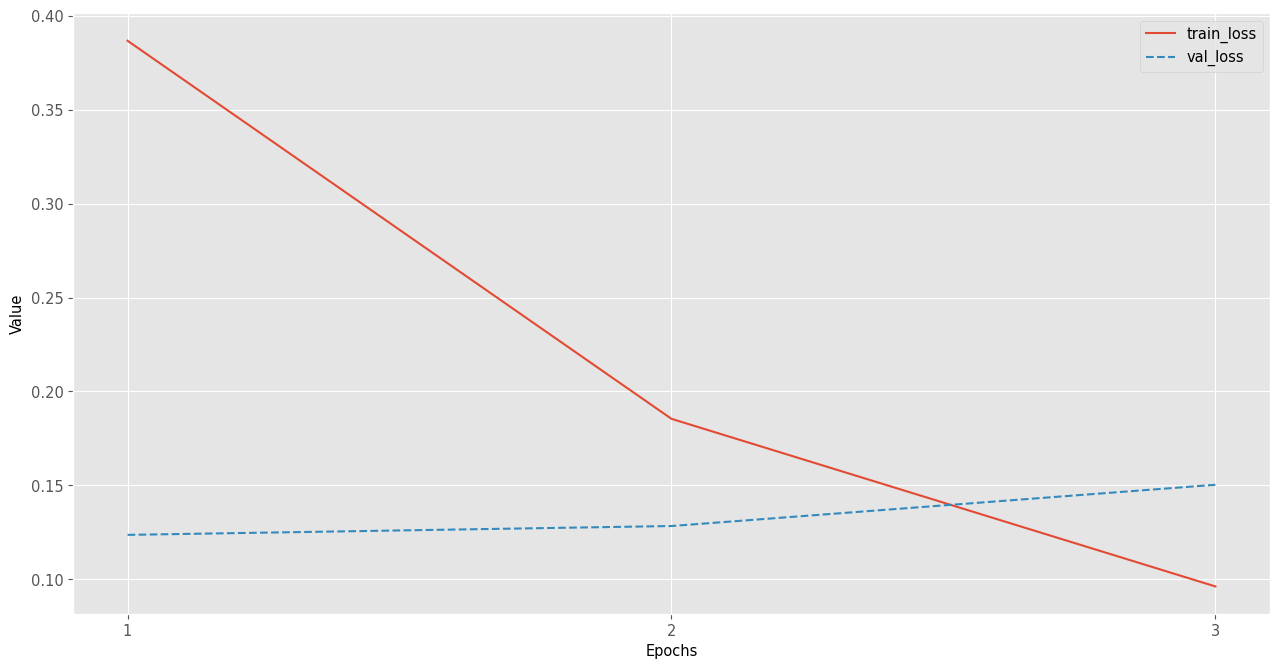

/usr/local/lib/python3.10/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


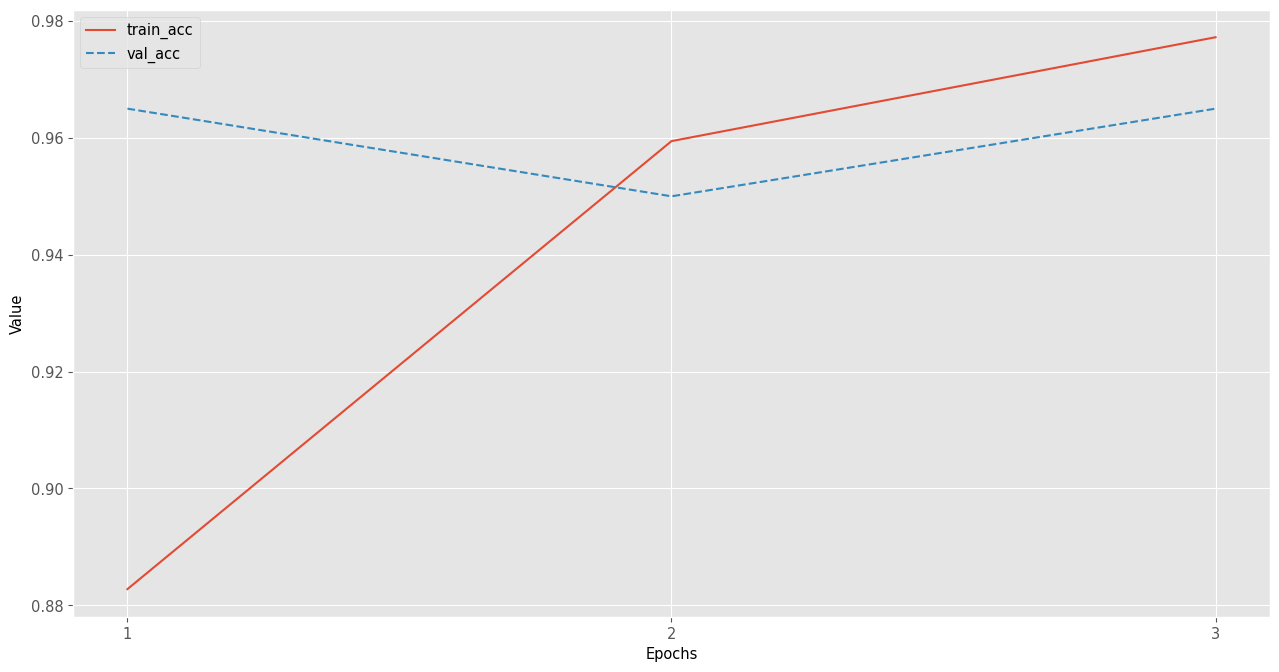

In [7]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/50 [00:00<?, ?it/s]

                precision    recall  f1-score   support

      criminal       0.98      0.95      0.96       100
administrative       0.95      0.98      0.97       100

      accuracy                           0.96       200
     macro avg       0.97      0.96      0.96       200
  weighted avg       0.97      0.96      0.96       200

Normalized confusion matrix


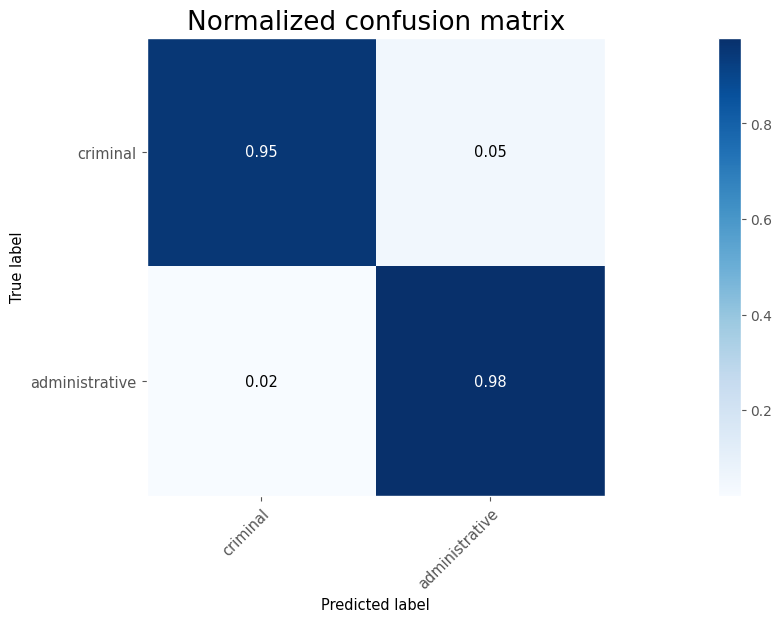

In [8]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

## **Final Note**

If you made it this far **Congrats!** 🎊 and **Thank you!** 🙏 for your interest in my tutorial!

I've been using this code for a while now and I feel it got to a point where is nicely documented and easy to follow.

Of course is easy for me to follow because I built it. That is why any feedback is welcome and it helps me improve my future tutorials!

If you see something wrong please let me know by opening an issue on my [ml_things GitHub repository](https://github.com/gmihaila/ml_things/issues)!

A lot of tutorials out there are mostly a one-time thing and are not being maintained. I plan on keeping my tutorials up to date as much as I can.

## **Contact** 🎣

🦊 GitHub: [gmihaila](https://github.com/gmihaila)

🌐 Website: [gmihaila.github.io](https://gmihaila.github.io/)

👔 LinkedIn: [mihailageorge](https://www.linkedin.com/in/mihailageorge/)

📓 Medium: [@gmihaila](https://gmihaila.medium.com)

📬 Email: [georgemihaila@my.unt.edu.com](mailto:georgemihaila@my.unt.edu.com?subject=GitHub%20Website)
